In [3]:
#load libraries
import numpy as np
import math
from math import sqrt
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean
from scipy.stats import norm, lognorm
import seaborn as sns
sns.set()
sns.set_style('white')
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance, Voronoi, voronoi_plot_2d, ConvexHull, Delaunay
from collections import defaultdict
import itertools
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random
import sys
from itertools import combinations 
import time
from scipy import stats
from sklearn.svm import SVC # "Support vector classifier"

In [4]:
#load data
raw_data = np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8))
raw_data_copy=np.copy(raw_data)

In [5]:
def js_divergence_scipy(hist1,hist2):
    #square distance to find divergence, use log2
    return (distance.jensenshannon(hist1, hist2, base=2))**2

In [6]:
def hellinger_dot(p, q):
    """Hellinger distance between two discrete distributions. 
       Using numpy.
       For Python >= 3.5 only"""
    z = np.sqrt(p) - np.sqrt(q)
    return np.sqrt(z @ z / 2)

In [7]:
# load file, skip header, load angles and coordinates, also grain ID
coords=np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(3,4))
grain_IDs=np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(8))
grain_IDs_and_edges=np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(8,9))
coords_and_grains=np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(3,4,8))
coords_and_grains_copy=np.copy(coords_and_grains)

In [8]:
uniquegrains=np.unique(grain_IDs,return_counts=True)
#unpack, ID is grain ID, count is number of occurences (grain size)
IDs, count = uniquegrains
# #make sure they add to one
# probability_vector=count/(np.sum(count))
# print(count)

In [9]:
edge_grains=grain_IDs_and_edges[np.where(grain_IDs_and_edges[:,1]==1)]

In [66]:
# #go through IDs to see if they have an edge pixel
# for ID in IDs:
#     #all rows with the ID
#     ID_rows=grain_IDs_and_edges[np.where(grain_IDs_and_edges[:,0] == ID)]
#     #search for one in edge column
#     for row in ID_rows:
#         #if it's an edge
#         if row[1]==1:
#             #double count in the same index as the edge ID
#             ind=np.where(IDs == ID)
#             count[int(ind[0])]*=2
#             #only double once
#             break
#         else:
#             continue
            
# # print(count)
# # print(count[450:550])

In [67]:
# def double_edge_grains(sample):
#     for ID in IDs:
#     #all rows with the ID
#     ID_rows=sample[np.where(sample[:,0] == ID)]
#     #search for one in edge column
#     for row in ID_rows:
#         #if it's an edge
#         if row[1]==1:
#             #double count in the same index as the edge ID
#             ind=np.where(IDs == ID)
#             count[int(ind[0])]*=2
#             #only double once
#             break
#         else:
#             continue
    

In [103]:
print(count)

[29 52 47 ... 14 15 10]


In [100]:
print(109.6**2/87017)

0.13804383051587618


In [104]:
print(0.138*count)

[4.002 7.176 6.486 ... 1.932 2.07  1.38 ]


In [105]:
micron_count=0.138*count

Text(0, 0.5, 'Frequency')

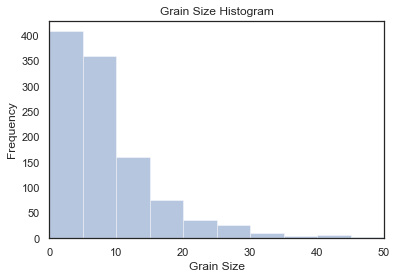

In [112]:
#if density doesn't work, just normalize by sum, bin size determined by 
p_hist, p_bin_edges = np.histogram(count, bins=np.arange(0,249,5), density=True)
p_hist = np.append(p_hist, 0)
p=p_hist
p[p==0]=[0.0000000000001]
#p_hist = np.append(p_hist, 0)
# #probability vector
# print(p_hist)
# #grain IDs
# print(p_bin_edges)
sns.distplot(micron_count, p_bin_edges,kde=False) 
plt.xlim(0, 50)
# plt.ylim(0, 0.025)
plt.title("Grain Size Histogram")
plt.xlabel('Grain Size')
plt.ylabel('Frequency')

# plt.hist(count, bins=np.arange(249), range=(0,250), density=True)

In [136]:
def new_p(binsize):
    p_hist, p_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    p_hist = np.append(p_hist, 0)
    p_hist[p_hist==0]=[0.0000000000001]
    p=p_hist
    return p
#     return p, p_bin_edges

In [10]:
#get area of each voronoi region
def voronoi_volumes(points):
    v = Voronoi(points)
    #create zeros of len points
    vol = np.zeros(v.npoints)
    #create vol index and get index of voronoi region for input point 
    for i, reg_num in enumerate(v.point_region):
        #get indices of each region
        indices = v.regions[reg_num]
        #-1 means vertex outside diagram
        if -1 in indices: # some regions can be opened
            #ignore infinite regions
            vol[i] = 0
            
        else: #can compute area, use convex hull
            vert=v.vertices[indices]
            vert[np.where(vert<0)]=0
            vert[np.where(vert>110)]=110
            vol[i] = ConvexHull(vert).volume
                      
#             edge=0
#             small=np.where(vert<0)
#             large=np.where(vert>110)
#             if ((len(small[0])) > 0 or (len(large[0])) > 0):
#                 edge=1
#                 vert[small]=0
#                 vert[large]=110            
#             if edge==1: #double size of edge grains
#                 vol[i] = (2*ConvexHull(vert).volume)
#             else: #all vertices are inside 
#                 vol[i] = ConvexHull(vert).volume
                
    #can use grain IDs, since areas match input point
    return vol

In [19]:
def new_vor_p(num_bins=25):
    #get areas
    vol=voronoi_volumes(coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = 0.138*unique_grain_IDs_and_total_areas[:,1]
    
    plt.title('100% of Data')
    plt.xlabel('Grain Size')
    plt.ylabel('Frequency')
    plt.xlim(0,50)
#     plt.ylim(0,0.04)
    plt.hist(count, bins=num_bins, range=(0,50), density=True)
     
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q

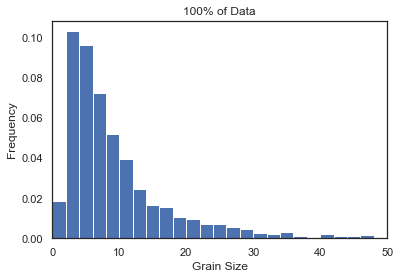

In [20]:
k3=new_vor_p(25)

In [28]:
def random_vor(sample,num_bins=25,hist=True,mean_var=False,replacement=False):
    #choose random points
    random_coords_and_grains=coords_and_grains[np.random.choice(coords_and_grains.shape[0], sample, replace=replacement), :]
    random_coords=random_coords_and_grains[:,0:2]
    random_grain_IDs=random_coords_and_grains[:,2]
    
    #get areas
    vol=voronoi_volumes(random_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((random_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = 0.138*unique_grain_IDs_and_total_areas[:,1]
     
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [12]:
# print(js_divergence_scipy(new_vor_p(249),random_vor(87017)))

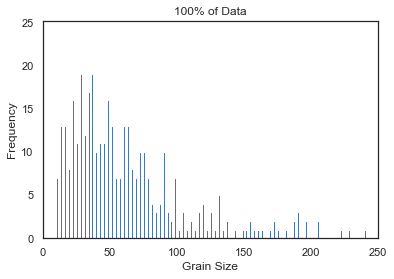

In [231]:
k2=new_vor_p(249)

In [15]:
# total_mean=np.mean(count)
# print(total_mean)
# total_var=np.var(count)
# print(total_var)

In [16]:
def grid(res,start=0,num_bins=25):
    grid_grain_IDs=grain_IDs[start::res]
    print(len(grid_grain_IDs))
    grid_unique_grains=np.unique(grid_grain_IDs,return_counts=True)
    grid_ID, grid_count = grid_unique_grains
    scale=(int(len(grain_IDs)))/(int(len(grid_grain_IDs)))
    print(scale)
    scaled_grid_count=scale*grid_count
    
    for ID in grid_ID:
        #all rows with the ID
        ID_rows=grain_IDs_and_edges[np.where(grain_IDs_and_edges[:,0] == ID)]
        #search for one in edge column
        for row in ID_rows:
            #if it's an edge
            if row[1]==1:
                #double count in the same index as the edge ID
                ind=np.where(IDs == ID)
                scaled_grid_count[int(ind[0])]*=2
                #only double once
                break
            else:
                continue
    
    q_hist, q_bin_edges = np.histogram(scaled_grid_count, bins=num_bins, range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q
#     return scaled_grid_count, q_bin_edges
#     return q,q_bin_edges

In [78]:
# print(js_divergence_scipy(new_p(249),grid(1)))

In [79]:
# print(js_divergence_scipy(new_p(249),grid_vor(87017)))

In [80]:
# from scipy.spatial.distance import euclidean
# from scipy.linalg import norm

# _SQRT2 = np.sqrt(2)     # sqrt(2) with default precision np.float64

# def hellinger1(p, q):
#     return norm(np.sqrt(p) - np.sqrt(q)) / _SQRT2

# def hellinger2(p, q):
#     return euclidean(np.sqrt(p), np.sqrt(q)) / _SQRT2

# #fastest?
# def hellinger3(p, q):
#     return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [255]:
# #symmetric & ranges from 0 (similar) to 1 (different)
# print(hellinger_dot(new_p(249),random(22000)))
# print(hellinger_dot(new_p(249),random(44000)))
# print(hellinger_dot(new_p(249),random(87000)))
# print(hellinger_dot(random(22000),new_p(249)))
# print(hellinger_dot(random(44000),new_p(249)))
# print(hellinger_dot(random(87000),new_p(249)))

0.7298746928652058
0.5813693150023891
0.1342834865690379
0.7292345495412028
0.5872758137801495
0.13364345908895417


In [17]:
def grain_rect_map(percent):
    percent=percent/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]<int((110*percent))) and (coords_and_grains_copy[index,1]<int((110*percent))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    xcoords, ycoords = coords_and_grains_slice[:,0], coords_and_grains_slice[:,1]
    plt.xlim(0, 110)
    plt.ylim(0, 110)
    plt.scatter(xcoords, ycoords, marker="o", alpha=0.5)

In [18]:
# def grain_rect_count_1(percent1,percent2):
#     percent1=percent1/100
#     percent2=percent2/100
#     row_list=[]
#     for index in range(0,len(coords_and_grains)):
#         if (coords_and_grains_copy[index,0]<int((110*percent1))) and (coords_and_grains_copy[index,1]<int((110*percent2))):
#             row_list.append(coords_and_grains_copy[index])
#         else:
#             continue

#     row_tuple=tuple(row_list)
#     coords_and_grains_slice=np.vstack(row_tuple)
#     uniquegrains=np.unique(coords_and_grains_slice[:,2],return_counts=True)
#     ID, rect_count = uniquegrains

    
    
    
# #     q_hist, q_bin_edges = np.histogram(rect_count, bins=np.arange(249), range=(0,250), density=True)
#     q_hist = np.append(q_hist, 0)
#     q=q_hist
#     q[q==0]=[0.0000000000001]
#     return q

In [19]:
def grain_rect_count_1(percent1,percent2,binsize=249):
    percent1=percent1/100
    percent2=percent2/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]<int((110*percent1))) and (coords_and_grains_copy[index,1]<int((110*percent2))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    grains_slice=coords_and_grains_slice[:,2]
    uniquegrains=np.unique(grains_slice,return_counts=True)
    IDs, count = uniquegrains
    
    #create array to hold grain IDs and edge column
    edges=np.zeros((len(coords_and_grains_slice),1))
    coords_and_grain_slice_with_edges=np.concatenate((coords_and_grains_slice,edges.reshape(-1,1)),axis=1)
    
    #min x
    left_edge=np.amin(coords_and_grains_slice[:,0])
    #max x
    right_edge=np.amax(coords_and_grains_slice[:,0])
    #min y
    bottom_edge=np.amin(coords_and_grains_slice[:,1])
    #max y
    top_edge=np.amax(coords_and_grains_slice[:,1])
    #assign edge grains
    for row in coords_and_grain_slice_with_edges:
        #x values
        if row[0] <= left_edge or row[0] >= right_edge:
            #it's an edge
            row[3]=1
        #y values
        if row[1] <= bottom_edge or row[1] >= top_edge:
            #it's an edge
            row[3]=1
            
    #plot showing edges
#     sns.scatterplot(x=coords_and_grain_slice_with_edges[:,0],y=coords_and_grain_slice_with_edges[:,1],marker='o',hue=coords_and_grain_slice_with_edges[:,3])
            
    #slice array for edge calculation
    grain_slice_and_edges=coords_and_grain_slice_with_edges[:,2:4]
    
    #double window edge grains
    for ID in IDs:
    #all rows with the ID
        ID_rows=grain_slice_and_edges[np.where(grain_slice_and_edges[:,0] == ID)]
        #search for one in edge column
        for row in ID_rows:
            #if it's an edge
            if row[1]==1:
                #double count in the same index as the edge ID
                ind=np.where(IDs == ID)
                count[int(ind[0])]*=2
                #only double once
                break
            else:
                continue
    
#     plt.xlim(0,250)
#     plt.hist(count, bins=np.arange(binsize), range=(0,250), density=True)
    
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q

In [19]:
def grain_rect_map_1(percent1,percent2):
    percent1=percent1/100
    percent2=percent2/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]<int((110*percent1))) and (coords_and_grains_copy[index,1]<int((110*percent2))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    xcoords, ycoords = coords_and_grains_slice[:,0], coords_and_grains_slice[:,1]
    plt.xlim(0, 110)
    plt.ylim(0, 110)
    plt.scatter(xcoords, ycoords, marker="o", alpha=0.5)
    #return coords_and_grains_slice[:,0], coords_and_grains_slice[:,1]

In [20]:
#top half
# grain_rect_map_1(100,50)

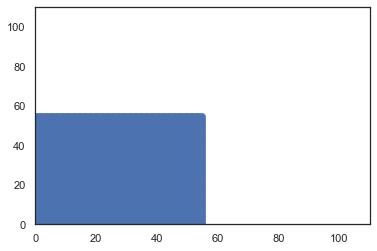

In [21]:
x=25
grain_rect_map_1(sqrt(x*100),sqrt(x*100))

In [22]:
# #left half
# grain_rect_map_1(50,100)

In [23]:
# def grain_rect_count_2(percent1,percent2):
#     percent1=percent1/100
#     percent2=percent2/100
#     row_list=[]
#     for index in range(0,len(coords_and_grains)):
#         if (coords_and_grains_copy[index,0]>int((110*percent1))) and (coords_and_grains_copy[index,1]>int((110*percent2))):
#             row_list.append(coords_and_grains_copy[index])
#         else:
#             continue

#     row_tuple=tuple(row_list)
#     coords_and_grains_slice=np.vstack(row_tuple)
#     uniquegrains=np.unique(coords_and_grains_slice[:,2],return_counts=True)
#     ID, rect_count = uniquegrains
# #     #no need to scale
# #     scale=(int(len(grain_IDs)))/(len(row_list))
# #     scaled_rect_count=scale*rect_count
# #     return rect_count
#     q_hist, q_bin_edges = np.histogram(rect_count, bins=np.arange(249), range=(0,250), density=True)
#     q_hist = np.append(q_hist, 0)
#     q=q_hist
#     q[q==0]=[0.0000000000001]
#     return q

In [24]:
def grain_rect_count_2(percent1,percent2,binsize=249):
    percent1=percent1/100
    percent2=percent2/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]>int((110*percent1))) and (coords_and_grains_copy[index,1]>int((110*percent2))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    grains_slice=coords_and_grains_slice[:,2]
    uniquegrains=np.unique(grains_slice,return_counts=True)
    IDs, count = uniquegrains
    
    #create array to hold grain IDs and edge column
    edges=np.zeros((len(coords_and_grains_slice),1))
    coords_and_grain_slice_with_edges=np.concatenate((coords_and_grains_slice,edges.reshape(-1,1)),axis=1)
    
    #min x
    left_edge=np.amin(coords_and_grains_slice[:,0])
    #max x
    right_edge=np.amax(coords_and_grains_slice[:,0])
    #min y
    bottom_edge=np.amin(coords_and_grains_slice[:,1])
    #max y
    top_edge=np.amax(coords_and_grains_slice[:,1])
    #assign edge grains
    for row in coords_and_grain_slice_with_edges:
        #x values
        if row[0] <= left_edge or row[0] >= right_edge:
            #it's an edge
            row[3]=1
        #y values
        if row[1] <= bottom_edge or row[1] >= top_edge:
            #it's an edge
            row[3]=1
            
    #plot showing edges
#     sns.scatterplot(x=coords_and_grain_slice_with_edges[:,0],y=coords_and_grain_slice_with_edges[:,1],marker='o',hue=coords_and_grain_slice_with_edges[:,3])
            
    #slice array for edge calculation
    grain_slice_and_edges=coords_and_grain_slice_with_edges[:,2:4]
    
    #double window edge grains
    for ID in IDs:
    #all rows with the ID
        ID_rows=grain_slice_and_edges[np.where(grain_slice_and_edges[:,0] == ID)]
        #search for one in edge column
        for row in ID_rows:
            #if it's an edge
            if row[1]==1:
                #double count in the same index as the edge ID
                ind=np.where(IDs == ID)
                count[int(ind[0])]*=2
                #only double once
                break
            else:
                continue
    
#     plt.xlim(0,250)
#     plt.hist(count, bins=np.arange(binsize), range=(0,250), density=True)
    
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q

In [25]:
# sns.distplot(grain_rect_count_2(50,50), hist=True, bins=250, kde=True)
# plt.xlim(0, 250)
# plt.title("Grain Size Histogram")
# plt.xlabel('Grain Size')
# plt.ylabel('Frequency')

In [26]:
# #actual histogram
# sns.distplot(count, hist=True, bins=250, kde=True)
# plt.xlim(0, 250)
# plt.title("Grain Size Histogram")
# plt.xlabel('Grain Size')
# plt.ylabel('Frequency')

In [27]:
def grain_rect_map_2(percent1,percent2):
    percent1=percent1/100
    percent2=percent2/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]>int((110*percent1))) and (coords_and_grains_copy[index,1]>int((110*percent2))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    xcoords, ycoords = coords_and_grains_slice[:,0], coords_and_grains_slice[:,1]
    plt.xlim(0, 110)
    plt.ylim(0, 110)
    plt.scatter(xcoords, ycoords, marker="o", alpha=0.5)
    #return coords_and_grains_slice[:,0], coords_and_grains_slice[:,1]

In [28]:
# #top half
# grain_rect_map_2(0,50)

In [29]:
# #right half
# grain_rect_map_2(50,0)

In [30]:
# def grain_rect_count_3(percent1,percent2):
#     percent1=percent1/100
#     percent2=percent2/100
#     row_list=[]
#     for index in range(0,len(coords_and_grains)):
#         if (coords_and_grains_copy[index,0]<int((110*percent1))) and (coords_and_grains_copy[index,1]>int((110*percent2))):
#             row_list.append(coords_and_grains_copy[index])
#         else:
#             continue

#     row_tuple=tuple(row_list)
#     coords_and_grains_slice=np.vstack(row_tuple)
#     uniquegrains=np.unique(coords_and_grains_slice[:,2],return_counts=True)
#     ID, rect_count = uniquegrains
#     q_hist, q_bin_edges = np.histogram(rect_count, bins=np.arange(249), range=(0,250), density=True)
#     q_hist = np.append(q_hist, 0)
#     q=q_hist
#     q[q==0]=[0.0000000000001]
#     return q

In [31]:
def grain_rect_count_3(percent1,percent2,binsize=249):
    percent1=percent1/100
    percent2=percent2/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]<int((110*percent1))) and (coords_and_grains_copy[index,1]>int((110*percent2))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    grains_slice=coords_and_grains_slice[:,2]
    uniquegrains=np.unique(grains_slice,return_counts=True)
    IDs, count = uniquegrains
    
    #create array to hold grain IDs and edge column
    edges=np.zeros((len(coords_and_grains_slice),1))
    coords_and_grain_slice_with_edges=np.concatenate((coords_and_grains_slice,edges.reshape(-1,1)),axis=1)
    
    #min x
    left_edge=np.amin(coords_and_grains_slice[:,0])
    #max x
    right_edge=np.amax(coords_and_grains_slice[:,0])
    #min y
    bottom_edge=np.amin(coords_and_grains_slice[:,1])
    #max y
    top_edge=np.amax(coords_and_grains_slice[:,1])
    #assign edge grains
    for row in coords_and_grain_slice_with_edges:
        #x values
        if row[0] <= left_edge or row[0] >= right_edge:
            #it's an edge
            row[3]=1
        #y values
        if row[1] <= bottom_edge or row[1] >= top_edge:
            #it's an edge
            row[3]=1
            
    #plot showing edges
#     sns.scatterplot(x=coords_and_grain_slice_with_edges[:,0],y=coords_and_grain_slice_with_edges[:,1],marker='o',hue=coords_and_grain_slice_with_edges[:,3])
            
    #slice array for edge calculation
    grain_slice_and_edges=coords_and_grain_slice_with_edges[:,2:4]
    
    #double window edge grains
    for ID in IDs:
    #all rows with the ID
        ID_rows=grain_slice_and_edges[np.where(grain_slice_and_edges[:,0] == ID)]
        #search for one in edge column
        for row in ID_rows:
            #if it's an edge
            if row[1]==1:
                #double count in the same index as the edge ID
                ind=np.where(IDs == ID)
                count[int(ind[0])]*=2
                #only double once
                break
            else:
                continue
    
#     plt.xlim(0,250)
#     plt.hist(count, bins=np.arange(binsize), range=(0,250), density=True)
    
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q

In [32]:
def grain_rect_map_3(percent1,percent2):
    percent1=percent1/100
    percent2=percent2/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]<int((110*percent1))) and (coords_and_grains_copy[index,1]>int((110*percent2))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    xcoords, ycoords = coords_and_grains_slice[:,0], coords_and_grains_slice[:,1]
    plt.xlim(0, 110)
    plt.ylim(0, 110)
    plt.scatter(xcoords, ycoords, marker="o", alpha=0.5)
    #return coords_and_grains_slice[:,0], coords_and_grains_slice[:,1]

In [33]:
# def grain_rect_count_4(percent1,percent2):
#     percent1=percent1/100
#     percent2=percent2/100
#     row_list=[]
#     for index in range(0,len(coords_and_grains)):
#         if (coords_and_grains_copy[index,0]>int((110*percent1))) and (coords_and_grains_copy[index,1]<int((110*percent2))):
#             row_list.append(coords_and_grains_copy[index])
#         else:
#             continue

#     row_tuple=tuple(row_list)
#     coords_and_grains_slice=np.vstack(row_tuple)
#     uniquegrains=np.unique(coords_and_grains_slice[:,2],return_counts=True)
#     ID, rect_count = uniquegrains
#     q_hist, q_bin_edges = np.histogram(rect_count, bins=np.arange(249), range=(0,250), density=True)
#     q_hist = np.append(q_hist, 0)
#     q=q_hist
#     q[q==0]=[0.0000000000001]
#     return q

In [34]:
def grain_rect_count_4(percent1,percent2,binsize=249):
    percent1=percent1/100
    percent2=percent2/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]>int((110*percent1))) and (coords_and_grains_copy[index,1]<int((110*percent2))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    grains_slice=coords_and_grains_slice[:,2]
    uniquegrains=np.unique(grains_slice,return_counts=True)
    IDs, count = uniquegrains
    
    #create array to hold grain IDs and edge column
    edges=np.zeros((len(coords_and_grains_slice),1))
    coords_and_grain_slice_with_edges=np.concatenate((coords_and_grains_slice,edges.reshape(-1,1)),axis=1)
    
    #min x
    left_edge=np.amin(coords_and_grains_slice[:,0])
    #max x
    right_edge=np.amax(coords_and_grains_slice[:,0])
    #min y
    bottom_edge=np.amin(coords_and_grains_slice[:,1])
    #max y
    top_edge=np.amax(coords_and_grains_slice[:,1])
    #assign edge grains
    for row in coords_and_grain_slice_with_edges:
        #x values
        if row[0] <= left_edge or row[0] >= right_edge:
            #it's an edge
            row[3]=1
        #y values
        if row[1] <= bottom_edge or row[1] >= top_edge:
            #it's an edge
            row[3]=1
            
    #plot showing edges
#     sns.scatterplot(x=coords_and_grain_slice_with_edges[:,0],y=coords_and_grain_slice_with_edges[:,1],marker='o',hue=coords_and_grain_slice_with_edges[:,3])
            
    #slice array for edge calculation
    grain_slice_and_edges=coords_and_grain_slice_with_edges[:,2:4]
    
    #double window edge grains
    for ID in IDs:
    #all rows with the ID
        ID_rows=grain_slice_and_edges[np.where(grain_slice_and_edges[:,0] == ID)]
        #search for one in edge column
        for row in ID_rows:
            #if it's an edge
            if row[1]==1:
                #double count in the same index as the edge ID
                ind=np.where(IDs == ID)
                count[int(ind[0])]*=2
                #only double once
                break
            else:
                continue
    
#     plt.xlim(0,250)
#     plt.hist(count, bins=np.arange(binsize), range=(0,250), density=True)
    
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q

In [35]:
def grain_rect_map_4(percent1,percent2):
    percent1=percent1/100
    percent2=percent2/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]>int((110*percent1))) and (coords_and_grains_copy[index,1]<int((110*percent2))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    xcoords, ycoords = coords_and_grains_slice[:,0], coords_and_grains_slice[:,1]
    plt.xlim(0, 110)
    plt.ylim(0, 110)
    plt.scatter(xcoords, ycoords, marker="o", alpha=0.5)
    #return coords_and_grains_slice[:,0], coords_and_grains_slice[:,1]

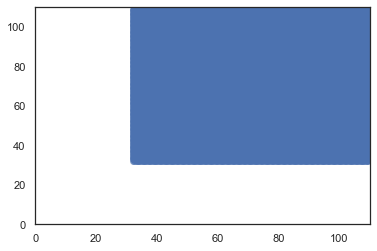

In [91]:
grain_rect_map_2(100-sqrt(x*100),100-sqrt(x*100))

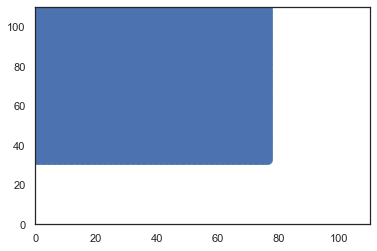

In [92]:
grain_rect_map_3(sqrt(x*100),100-sqrt(x*100))

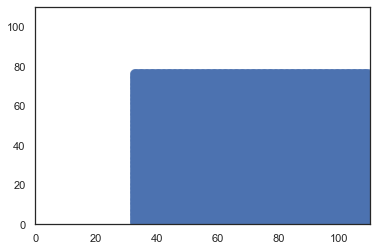

In [93]:
grain_rect_map_4(100-sqrt(x*100),sqrt(x*100))

In [25]:
# def random_vor(sample,binsize=249,hist=True,mean_var=False):
#     #choose random points
#     random_coords_and_grains=coords_and_grains[np.random.choice(coords_and_grains.shape[0], sample, replace=False), :]
#     random_coords=random_coords_and_grains[:,0:2]
#     random_grain_IDs=random_coords_and_grains[:,2]
    
#     #get areas
#     vol=voronoi_volumes(random_coords)   
#     #turn area into percent of total area
#     norm_vol=(vol)/sum(vol)
#     #multiply by total number of pixels to find how many pixels in each area
#     scale_vol=norm_vol*87017
#     #round to nearest whole number
#     round_vol=np.round(scale_vol,decimals=0)
#     #create array, col1 is ID, col2 is area
#     grain_IDs_and_areas=np.stack((random_grain_IDs,round_vol),axis=1)
#     #get unique IDs and their count
#     unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
#     #create array to hold unique IDs and their sizes added together
#     unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
#     #construct IDs and count
#     for row in unique_grain_IDs_and_total_areas:
#         grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
#         total=np.sum(grain[:,1])
#         row[1]=total
    
#     #double edge grains
#     row_ID=0
#     for row in unique_grain_IDs_and_total_areas:
#         #if the grain ID is an edge
#         if np.isin(row[0],edge_grains[:,0]):
#             #double the total grain area
#             unique_grain_IDs_and_total_areas[row_ID,1]*=2
#         row_ID+=1
        
#     #return count for hist
#     count = unique_grain_IDs_and_total_areas[:,1]
     
#     q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
#     q_hist = np.append(q_hist, 0)
#     q=q_hist
#     q[q==0]=[0.0000000000001]
#     if hist==True:
#         return q
    
#     if mean_var==True:
#         mean=np.mean(count)
#         var=np.var(count)
#         return mean, var

In [21]:
def new_p_vor(binsize):
    #get areas
    vol=voronoi_volumes(coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = unique_grain_IDs_and_total_areas[:,1]
     
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q

In [34]:
#get area of each voronoi region
def window_voronoi_volumes(points,percent):
    v = Voronoi(points)
    #create zeros of len points
    vol = np.zeros(v.npoints)
    #create vol index and get index of voronoi region for input point 
    for i, reg_num in enumerate(v.point_region):
        #get indices of each region
        indices = v.regions[reg_num]
        #-1 means vertex outside diagram
        if -1 in indices: # some regions can be opened
            #ignore infinite regions
            vol[i] = 0
            
        else: #can compute area, use convex hull
            vert=v.vertices[indices]
            vert[np.where(vert<0)]=0
            vert[np.where(vert>(110*percent))]=(110*percent)
            vol[i] = ConvexHull(vert).volume
                      
#             edge=0
#             small=np.where(vert<0)
#             large=np.where(vert>110)
#             if ((len(small[0])) > 0 or (len(large[0])) > 0):
#                 edge=1
#                 vert[small]=0
#                 vert[large]=110            
#             if edge==1: #double size of edge grains
#                 vol[i] = (2*ConvexHull(vert).volume)
#             else: #all vertices are inside 
#                 vol[i] = ConvexHull(vert).volume
                
    #can use grain IDs, since areas match input point
    return vol

In [30]:
def grain_rect_count_vor(percent,num_bins=25,hist=True,mean_var=False):
    percent=percent/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]<=int((110*percent))) and (coords_and_grains_copy[index,1]<=int((110*percent))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    coords_slice=coords_and_grains_slice[:,0:2]
    grains_slice=coords_and_grains_slice[:,2]
    
    #volume is not constant!
    
    #get areas
    vol=window_voronoi_volumes(coords_slice,percent)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
#     scale_vol=norm_vol*87017
    scale_vol=norm_vol*len(coords_and_grains_slice)
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((grains_slice,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #create array to hold grain IDs and edge column
    edges=np.zeros((len(coords_and_grains_slice),1))
    coords_and_grain_slice_with_edges=np.concatenate((coords_and_grains_slice,edges.reshape(-1,1)),axis=1)
    
    #min x
    left_edge=np.amin(coords_and_grains_slice[:,0])
    #max x
    right_edge=np.amax(coords_and_grains_slice[:,0])
    #min y
    bottom_edge=np.amin(coords_and_grains_slice[:,1])
    #max y
    top_edge=np.amax(coords_and_grains_slice[:,1])
    #assign edge grains
    for row in coords_and_grain_slice_with_edges:
        #x values
        if row[0] <= left_edge or row[0] >= right_edge:
            #it's an edge
            row[3]=1
        #y values
        if row[1] <= bottom_edge or row[1] >= top_edge:
            #it's an edge
            row[3]=1
            
    
    #slice array for edge calculation
    grain_slice_and_edges=coords_and_grain_slice_with_edges[:,2:4]
    edge_grains=grain_slice_and_edges[np.where(grain_slice_and_edges[:,1]==1)]
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
    
    #create count
    uniquegrains=np.unique(grains_slice,return_counts=True)
    IDs, count = uniquegrains
    
    #return count for hist
    count = 0.138*unique_grain_IDs_and_total_areas[:,1]
    
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var
#     return np.std(count)
#     return count, q_bin_edges
#     return q,q_bin_edges

In [58]:
# grain_rect_count_vor(100)

87017


In [60]:
# print(js_divergence_scipy(grain_rect_count_vor(100),k2))

0.0005658871539253571


In [24]:
def grain_rect_count(percent,binsize=249,hist=True,mean_var=False):
    percent=percent/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]<int((110*percent))) and (coords_and_grains_copy[index,1]<int((110*percent))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    grains_slice=coords_and_grains_slice[:,2]
    uniquegrains=np.unique(grains_slice,return_counts=True)
    IDs, count = uniquegrains
    
    #create array to hold grain IDs and edge column
    edges=np.zeros((len(coords_and_grains_slice),1))
    coords_and_grain_slice_with_edges=np.concatenate((coords_and_grains_slice,edges.reshape(-1,1)),axis=1)
    
    #min x
    left_edge=np.amin(coords_and_grains_slice[:,0])
    #max x
    right_edge=np.amax(coords_and_grains_slice[:,0])
    #min y
    bottom_edge=np.amin(coords_and_grains_slice[:,1])
    #max y
    top_edge=np.amax(coords_and_grains_slice[:,1])
    #assign edge grains
    for row in coords_and_grain_slice_with_edges:
        #x values
        if row[0] <= left_edge or row[0] >= right_edge:
            #it's an edge
            row[3]=1
        #y values
        if row[1] <= bottom_edge or row[1] >= top_edge:
            #it's an edge
            row[3]=1
            
    #plot showing edges
#     sns.scatterplot(x=coords_and_grain_slice_with_edges[:,0],y=coords_and_grain_slice_with_edges[:,1],marker='o',hue=coords_and_grain_slice_with_edges[:,3])
            
    #slice array for edge calculation
    grain_slice_and_edges=coords_and_grain_slice_with_edges[:,2:4]
    
    #double window edge grains
    for ID in IDs:
    #all rows with the ID
        ID_rows=grain_slice_and_edges[np.where(grain_slice_and_edges[:,0] == ID)]
        #search for one in edge column
        for row in ID_rows:
            #if it's an edge
            if row[1]==1:
                #double count in the same index as the edge ID
                ind=np.where(IDs == ID)
                count[int(ind[0])]*=2
                #only double once
                break
            else:
                continue
    
#     plt.xlim(0,250)
#     plt.hist(count, bins=np.arange(binsize), range=(0,250), density=True)
    
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var
#     return np.std(count)
#     return count, q_bin_edges
#     return q,q_bin_edges

In [118]:
window_percent=[]
for x in range(2,100):
    window_percent.append(x)

In [119]:
window_mean=[]
window_var=[]

for x in range(2,100):
    mean, var=grain_rect_count(sqrt(x*100),hist=False,mean_var=True)
    window_mean.append(mean)
    window_var.append(var)

window_std=np.sqrt(window_var)

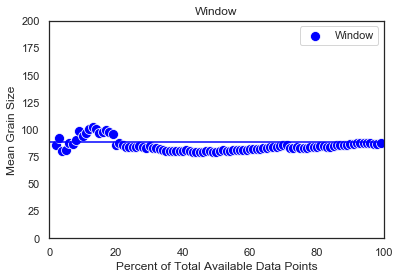

In [207]:
plt.xlim(0, 100)
# plt.ylim(-50000,50000)
plt.ylim(0,200)
plt.title('Window')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#window mean
sns.scatterplot(window_percent, window_mean, s=100, color="blue", marker="o", label='Window')
# plt.errorbar(window_percent, window_mean, yerr=window_var, fmt='o')
#total mean
plt.axhline(y=total_mean, color='blue', linestyle='-',label='total mean')

In [298]:
# # plt.xlim(0, 100)
# # plt.ylim(0, 1)
# #plt.title('JS Divergence of Dataset and Randomly Sampled Subset')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('Mean Grain Size')

# #window mean
# # sns.scatterplot(window_percent, window_mean, s=100, color="red", marker="o", label='mean')
# #window var
# sns.scatterplot(window_percent, window_var, s=100, color="blue", marker="o", label='var')

In [26]:
# def random_vor(sample,binsize=249,hist=True,mean_var=False):
#     #choose random points
#     random_coords_and_grains=coords_and_grains[np.random.choice(coords_and_grains.shape[0], sample, replace=False), :]
#     random_coords=random_coords_and_grains[:,0:2]
#     random_grain_IDs=random_coords_and_grains[:,2]
    
#     #get areas
#     vol=voronoi_volumes(random_coords)   
#     #turn area into percent of total area
#     norm_vol=(vol)/sum(vol)
#     #multiply by total number of pixels to find how many pixels in each area
#     scale_vol=norm_vol*87017
#     #round to nearest whole number
#     round_vol=np.round(scale_vol,decimals=0)
#     #create array, col1 is ID, col2 is area
#     grain_IDs_and_areas=np.stack((random_grain_IDs,round_vol),axis=1)
#     #get unique IDs and their count
#     unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
#     #create array to hold unique IDs and their sizes added together
#     unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
#     #construct IDs and count
#     for row in unique_grain_IDs_and_total_areas:
#         grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
#         total=np.sum(grain[:,1])
#         row[1]=total
    
#     #double edge grains
#     row_ID=0
#     for row in unique_grain_IDs_and_total_areas:
#         #if the grain ID is an edge
#         if np.isin(row[0],edge_grains[:,0]):
#             #double the total grain area
#             unique_grain_IDs_and_total_areas[row_ID,1]*=2
#         row_ID+=1
        
#     #return count for hist
#     count = 0.138*unique_grain_IDs_and_total_areas[:,1]
     
#     q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,50), density=True)
#     q_hist = np.append(q_hist, 0)
#     q=q_hist
#     q[q==0]=[0.0000000000001]
#     if hist==True:
#         return q
    
#     if mean_var==True:
#         mean=np.mean(count)
#         var=np.var(count)
#         return mean, var

In [274]:
random_percent=[]
for x in range (10,1000,1000):
    random_percent.append((x/87000)*100)
    
grid_percent=[]
for x in range(1,50,1):
    grid_percent.append(((87017/x)/87017)*100)
    
fine_grid_percent=[]
for x in range(2,50,1):
    fine_grid_percent.append(((87017-(87017/x))/87017)*100)

In [208]:
random_mean=[]
random_var=[]

for x in range (10,87000,1000):
    mean, var=random_vor(x,hist=False,mean_var=True)
    random_mean.append(mean)
    random_var.append(var)

random_std=np.sqrt(random_var)   

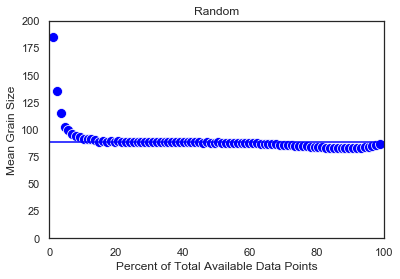

In [209]:
plt.xlim(0, 100)
plt.ylim(0,200)
plt.title('Random')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#window mean
sns.scatterplot(random_percent, random_mean, s=100, color="blue", marker="o")
# plt.errorbar(random_percent, random_mean, yerr=random_var, fmt='o')
#total mean
plt.axhline(y=total_mean, color='blue', linestyle='-',label='total mean')

In [29]:
def grid_vor(res,num_bins=25,hist=True,mean_var=False):
    #choose random points
    grid_coords_and_grain_IDs=coords_and_grains_copy[::res]
    grid_coords=grid_coords_and_grain_IDs[:,0:2]
    grid_grain_IDs=grid_coords_and_grain_IDs[:,2]
    
    #get areas
    vol=voronoi_volumes(grid_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((grid_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = 0.138*unique_grain_IDs_and_total_areas[:,1]
    
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,50), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [386]:
def jitter_2(res,array,randomness=0,num_bins=25,hist=True,mean_var=False):
    #array of points to randomly sample after removing duplicates
    sampled=np.zeros((len(array),1))
    array=np.concatenate((array,sampled.reshape(-1,1)),axis=1)
    
    #row_IDs to access unsampled points
    row_IDs=np.arange(0,len(array))
    array=np.concatenate((array,row_IDs.reshape(-1,1)),axis=1)
    
    #total number of points to randomly sample
    grid_row_IDs=row_IDs[::res]
    grid_row_IDs=grid_row_IDs.reshape(-1,1)
    
    #introduce randomness
    minimum=np.zeros((len(grid_row_IDs),1))
    minimum=minimum-randomness
    maximum=np.ones((len(grid_row_IDs),1))
    maximum=maximum+randomness
    min_max=np.concatenate((minimum.reshape(-1,1),maximum.reshape(-1,1)),axis=1)
    
    #ensure the range of values in within the array
    
    #add/subtract randomness
    randomness_array=np.zeros((len(grid_row_IDs),1))
    for row in np.arange(len(grid_row_IDs)):
        randomness_array[row]=np.random.randint(int(min_max[row,0]),int(min_max[row,1]))
    
    #add array to create jitter
    jitter_array=grid_row_IDs+randomness_array
    
    #remove points outside of range (0,len)...
    in_range=np.where((jitter_array[:,0] >= 0) & (jitter_array[:,0] < len(array)))
#     print(len(in_range[0]))
#     out_of_range=np.where((jitter_array[:,0] < 0) | (jitter_array[:,0] >= len(array)))
#     print(len(out_of_range[0]))
    jitter_array=jitter_array[in_range]
    
    #...and add back in by random sampling
    random_array=array[np.random.choice(array.shape[0], (len(grid_row_IDs)-len(in_range[0])), replace=True), 4]
    random_array=random_array.reshape(-1,1)
    jitter_array=np.append(jitter_array,random_array)
    jitter_array=jitter_array.reshape(-1,1)
    
    #jitter sample data
    jitter_coords_and_grain_IDs=array[jitter_array.astype(int).flatten(),:]
    jitter_coords=jitter_coords_and_grain_IDs[:,0:2]
    jitter_grain_IDs=jitter_coords_and_grain_IDs[:,2]
    
    #get areas
    vol=voronoi_volumes(jitter_coords)
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((jitter_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    print(unique_IDs)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = unique_grain_IDs_and_total_areas[:,1]
    
    plt.title('Jitter Sampling, 50% of Data, Jitter = ' + str(randomness))
    plt.xlabel('Grain Size')
    plt.ylabel('Frequency')
    plt.xlim(0,250)
    plt.ylim(0,0.04)
    plt.hist(count, bins=26, range=(0,250), density=True)
     
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [385]:
# def jitter_2(res,array,randomness=0,binsize=249,hist=True,mean_var=False):
#     #array of points to randomly sample after removing duplicates
#     sampled=np.zeros((len(array),1))
#     array=np.concatenate((array,sampled.reshape(-1,1)),axis=1)
    
#     #row_IDs to access unsampled points
#     row_IDs=np.arange(0,len(array))
#     array=np.concatenate((array,row_IDs.reshape(-1,1)),axis=1)
    
#     #total number of points to randomly sample
#     grid_row_IDs=row_IDs[::res]
#     grid_row_IDs=grid_row_IDs.reshape(-1,1)
    
#     #introduce randomness
#     minimum=np.zeros((len(grid_row_IDs),1))
#     minimum=minimum-randomness
#     maximum=np.ones((len(grid_row_IDs),1))
#     maximum=maximum+randomness
#     min_max=np.concatenate((minimum.reshape(-1,1),maximum.reshape(-1,1)),axis=1)
    
#     #ensure the range of values in within the array
    
#     #add/subtract randomness
#     randomness_array=np.zeros((len(grid_row_IDs),1))
#     for row in np.arange(len(grid_row_IDs)):
#         randomness_array[row]=np.random.randint(int(min_max[row,0]),int(min_max[row,1]))
    
#     #add array to create jitter
#     jitter_array=grid_row_IDs+randomness_array
    
#     #remove points outside of range (0,len)...
#     in_range=np.where((jitter_array[:,0] >= 0) & (jitter_array[:,0] < len(array)))
# #     print(len(in_range[0]))
# #     out_of_range=np.where((jitter_array[:,0] < 0) | (jitter_array[:,0] >= len(array)))
# #     print(len(out_of_range[0]))
#     jitter_array=jitter_array[in_range]
    
#     #...and add back in by random sampling
#     random_array=array[np.random.choice(array.shape[0], (len(grid_row_IDs)-len(in_range[0])), replace=True), 4]
#     random_array=random_array.reshape(-1,1)
#     jitter_array=np.append(jitter_array,random_array)
#     jitter_array=jitter_array.reshape(-1,1)
    
#     #jitter sample data
#     jitter_coords_and_grain_IDs=array[jitter_array.astype(int).flatten(),:]
#     jitter_coords=jitter_coords_and_grain_IDs[:,0:2]
#     jitter_grain_IDs=jitter_coords_and_grain_IDs[:,2]
    
#     #get areas
#     vol=voronoi_volumes(jitter_coords)
    
#     return vol
    
#     print('vol')
#     even=0
#     odd=0
#     for element in vol:
#         if element%2==0:
#             even+=1
#         else:
#             odd+=1
#     print(even)
#     print(odd)
    
#     #turn area into percent of total area
#     norm_vol=(vol)/sum(vol)
    
#     print('norm_vol')
#     even=0
#     odd=0
#     for element in norm_vol:
#         if element%2==0:
#             even+=1
#         else:
#             odd+=1
#     print(even)
#     print(odd)
    
#     #multiply by total number of pixels to find how many pixels in each area
#     scale_vol=norm_vol*87017
    
#     print('scale_vol')
#     even=0
#     odd=0
#     for element in scale_vol:
#         if element%2==0:
#             even+=1
#         else:
#             odd+=1
#     print(even)
#     print(odd)
    
# #     return scale_vol
    
#     #round to nearest whole number
#     round_vol=np.round(scale_vol,decimals=0)
    
#     print('round_vol')
#     even=0
#     odd=0
#     for element in round_vol:
#         if element%2==0:
#             even+=1
#         else:
#             odd+=1
#     print(even)
#     print(odd)
    
#     #create array, col1 is ID, col2 is area
#     grain_IDs_and_areas=np.stack((jitter_grain_IDs,round_vol),axis=1)

    
#     #get unique IDs and their count
#     unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    
#     print('unique_IDs_count')
#     even=0
#     odd=0
#     for element in unique_IDs_count:
#         if element%2==0:
#             even+=1
#         else:
#             odd+=1
#     print(even)
#     print(odd)
    
#     #create array to hold unique IDs and their sizes added together
#     unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
#     #construct IDs and count
#     for row in unique_grain_IDs_and_total_areas:
#         grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
#         total=np.sum(grain[:,1])
#         row[1]=total
        
#     print('unique_grain_IDs_and_total_areas[:,1]')
#     even=0
#     odd=0
#     for element in unique_grain_IDs_and_total_areas[:,1]:
#         if element%2==0:
#             even+=1
#         else:
#             odd+=1
#     print(even)
#     print(odd)
    
#     #double edge grains
#     row_ID=0
#     for row in unique_grain_IDs_and_total_areas:
#         #if the grain ID is an edge
#         if np.isin(row[0],edge_grains[:,0]):
#             #double the total grain area
#             unique_grain_IDs_and_total_areas[row_ID,1]*=2
#         row_ID+=1
        
#     print('unique_grain_IDs_and_total_areas[:,1]')
#     even=0
#     odd=0
#     for element in unique_grain_IDs_and_total_areas[:,1]:
#         if element%2==0:
#             even+=1
#         else:
#             odd+=1
#     print(even)
#     print(odd)
        
#     #return count for hist
#     count = unique_grain_IDs_and_total_areas[:,1]
    
#     print('count')
#     even=0
#     odd=0
#     for element in count:
#         if element%2==0:
#             even+=1
#         else:
#             odd+=1
#     print(even)
#     print(odd)
     
# #     q_hist, q_bin_edges = np.histogram(count, bins=25, range=(0,250), density=True)
# #     q_hist = np.append(q_hist, 0)
# #     q=q_hist
# #     q[q==0]=[0.0000000000001]
# #     if hist==True:
# #         return q
    
# #     if mean_var==True:
# #         mean=np.mean(count)
# #         var=np.var(count)
# #         return mean, var

In [28]:
#randomness is from 0 to 100, 0 is pure grid, 100 is pure random 
def jitter_grid_vor(res,randomness,binsize=249,hist=True,mean_var=False):
    #pure grid sampling
    grid_coords_and_grain_IDs=coords_and_grains_copy[::res]
    grid_coords=grid_coords_and_grain_IDs[:,0:2]
    grid_grain_IDs=grid_coords_and_grain_IDs[:,2]
    
    jitter_coords_and_grain_IDs=np.zeros(grid_coords_and_grain_IDs.shape[1])
    #array to hold sampled points
    sampled=np.zeros((len(coords_and_grains_copy),1))
    jitter_copy=np.concatenate((coords_and_grains_copy,sampled.reshape(-1,1)),axis=1)
    
    while len(jitter_coords_and_grain_IDs) < len(grid_coords_and_grain_IDs):
        jitter_array=jitter_copy[np.where(jitter_copy[:,3])==0]
        #scale res by 1 if grid (easy)
        #else scale res so it is inbetween start and last item (needs to be same as random)
        new_res=res*int(len(jitter_array)*random())
        jitter_coords_and_grain_IDs_slice=jitter_array[::res]    
            
            
    jitter_coords_and_grain_IDs=np.delete(jitter_coords_and_grain_IDs, 0, 0)
    jitter_coords=jitter_coords_and_grain_IDs[:,0:2]
    jitter_grain_IDs=jitter_coords_and_grain_IDs[:,2]
    
    #get areas
    vol=voronoi_volumes(jitter_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((jitter_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = unique_grain_IDs_and_total_areas[:,1]
    
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [268]:
grid_mean=[]
grid_var=[]

for x in range(1,50,1):
    mean, var=grid_vor(x,hist=False,mean_var=True)
    grid_mean.append(mean)
    grid_var.append(var)

grid_std=np.sqrt(grid_var)   

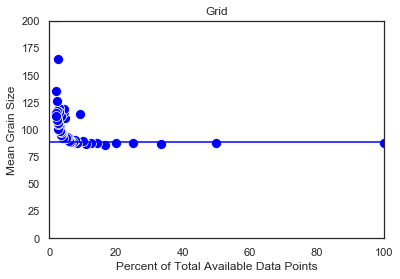

In [269]:
plt.xlim(0, 100)
# plt.ylim(-50000,50000)
plt.ylim(0,200)
plt.title('Grid')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#window mean
sns.scatterplot(grid_percent, grid_mean, s=100, color="blue", marker="o")
# plt.errorbar(grid_percent, grid_mean, yerr=grid_var, fmt='o')
#total mean
plt.axhline(y=total_mean, color='blue', linestyle='-',label='total mean')

In [297]:
# fine_grid_index=list(range (0,87017))
# fine_grid_index=np.delete(fine_grid_index, np.arange(0, len(fine_grid_index), 2))
# fine_grid_coords=coords_and_grains_copy[:,0:2]
# print(fine_grid_coords[fine_grid_index])

In [382]:
def fine_grid_vor(res,num_bins=25,hist=True,mean_var=False):
    #choose random points
    fine_grid_grain_IDs=coords_and_grains_copy[:,2]
    fine_grid_grain_IDs=np.delete(fine_grid_grain_IDs, np.arange(0, fine_grid_grain_IDs.size, res))
    
    fine_grid_index=list(range (0,87017))
    fine_grid_index=np.delete(fine_grid_index, np.arange(0, len(fine_grid_index), res))
    fine_grid_coords=coords_and_grains_copy[:,0:2]
    fine_grid_coords=fine_grid_coords[fine_grid_index]
    
    #get areas
    vol=voronoi_volumes(fine_grid_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((fine_grid_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
        
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
    
    #return count for hist
    count = unique_grain_IDs_and_total_areas[:,1]
    
#     plt.xlim(0,250)
#     plt.hist(count, bins=np.arange(binsize), range=(0,250), density=True, rwidth=10)
    
    q_hist, q_bin_edges = np.histogram(count, bins=num_bins, range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [271]:
fine_grid_mean=[]
fine_grid_var=[]

for x in range(2,50,1):
    mean, var=fine_grid_vor(x,hist=False,mean_var=True)
    fine_grid_mean.append(mean)
    fine_grid_var.append(var)

fine_grid_std=np.sqrt(fine_grid_var)   

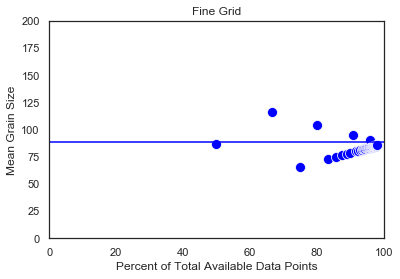

In [276]:
plt.xlim(0, 100)
plt.ylim(0,200)
plt.title('Fine Grid')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Mean Grain Size')

#window mean
sns.scatterplot(fine_grid_percent, fine_grid_mean, s=100, color="blue", marker="o")
# plt.errorbar(fine_grid_percent, fine_grid_mean, yerr=fine_grid_var, fmt='o')
#total mean
plt.axhline(y=total_mean, color='blue', linestyle='-',label='total mean')

In [ ]:
#still a bit odd looking

In [30]:
def fine_grid(res,binsize=249):
    grid_grain_IDs=np.delete(grain_IDs, np.arange(0, grain_IDs.size, res))
    grid_unique_grains=np.unique(grid_grain_IDs,return_counts=True)
    grid_ID, grid_count = grid_unique_grains
    scale=(int(len(grain_IDs)))/(int(len(grid_grain_IDs)))
    scaled_grid_count=scale*grid_count
    
#     plt.xlim(0,250)
#     plt.hist(scaled_grid_count, bins=np.arange(binsize), range=(0,250), density=True, rwidth=10)
    
    q_hist, q_bin_edges = np.histogram(scaled_grid_count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q 
#     return q, q_bin_edges

In [36]:
Window_20_Histogram,Window_20_Histogram_Edges=grain_rect_count(44.7)
Window_20=pd.DataFrame({'Window_20_Histogram': Window_20_Histogram, 'Window_20_Histogram_Edges': Window_20_Histogram_Edges})
print(Window_20)

ValueError: too many values to unpack (expected 2)

     Window_10_Histogram  Window_10_Histogram_Edges
0           1.000000e-13                          0
1           1.000000e-13                          1
2           1.000000e-13                          2
3           1.000000e-13                          3
4           1.000000e-13                          4
..                   ...                        ...
244         1.000000e-13                        244
245         1.000000e-13                        245
246         1.000000e-13                        246
247         1.000000e-13                        247
248         1.000000e-13                        248

[249 rows x 2 columns]


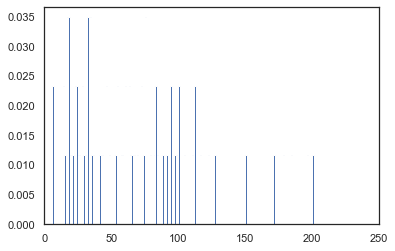

In [288]:
Window_10_Histogram,Window_10_Histogram_Edges=grain_rect_count(26.5)
Window_10=pd.DataFrame({'Window_10_Histogram': Window_10_Histogram, 'Window_10_Histogram_Edges': Window_10_Histogram_Edges})
print(Window_10)

In [289]:
with pd.ExcelWriter('Histograms January 15.xlsx') as writer:  
    Actual.to_excel(writer, sheet_name='Actual')
    Grid_50.to_excel(writer, sheet_name='Grid_50')
    Grid_80.to_excel(writer, sheet_name='Grid_80')
    Window_10.to_excel(writer, sheet_name='Window_10')
    Window_20.to_excel(writer, sheet_name='Window_20')

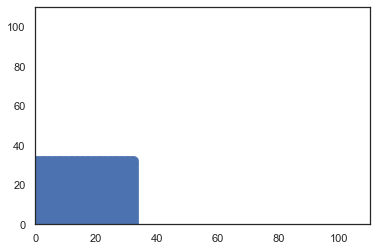

In [232]:
grain_rect_map(30)

26.457513110645905


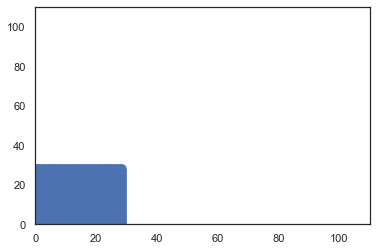

In [286]:
i=7
i=sqrt(i*100)
print(i)
grain_rect_map(i)
# print(js_divergence(grain_rect_count(i),new_p(249)))

In [186]:
# a,b=grain_rect_count(10)
# sns.distplot(a,b) 
# plt.xlim(0, 250)
# plt.title("Grain Size Histogram")
# plt.xlabel('Grain Size')
# plt.ylabel('Frequency')

In [24]:
# plt.bar(p_bin_edges[:-1], p_hist, width=1, color=(0, 0, 1, 1))
# plt.xlim(0, 250)
# plt.show()

In [159]:
# def random(sample,binsize=249):
#     #random_count = np.random.choice(count, sample, replace=False)
#     random_grain_IDs=np.random.choice(grain_IDs,sample, replace=False)
#     random_unique_grains=np.unique(random_grain_IDs,return_counts=True)
#     random_ID, random_count = random_unique_grains
#     scale=(int(len(grain_IDs)))/(sample)
#     scaled_random_count=scale*random_count
#     #return scaled_random_count
#     q_hist, q_bin_edges = np.histogram(scaled_random_count, bins=np.arange(binsize), range=(0,250), density=True)
#     q_hist = np.append(q_hist, 0)
#     q=q_hist
#     q[q==0]=[0.0000000000001]
#     return q
#     #return scaled_random_count, q_bin_edges

In [32]:
# a,b=random(44000)
# sns.distplot(a, b) 
# plt.xlim(0, 250)
# plt.title("Grain Size Histogram")
# plt.xlabel('Grain Size')
# plt.ylabel('Frequency')

In [280]:
Actual_Histogram,Actual_Histogram_Edges=new_p(249)
Actual=pd.DataFrame({'Actual_Histogram': Actual_Histogram, 'Actual_Histogram_Edges': Actual_Histogram_Edges})
print(Actual)

     Actual_Histogram  Actual_Histogram_Edges
0        1.000000e-13                       0
1        1.000000e-13                       1
2        1.000000e-13                       2
3        1.000000e-13                       3
4        1.000000e-13                       4
..                ...                     ...
244      9.460738e-04                     244
245      1.000000e-13                     245
246      1.000000e-13                     246
247      1.000000e-13                     247
248      1.000000e-13                     248

[249 rows x 2 columns]


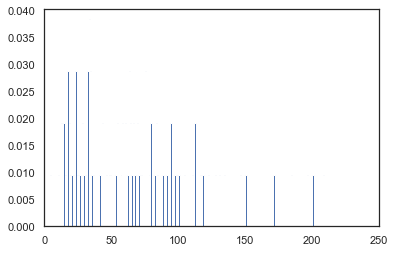

In [185]:
grain_rect_count(30)

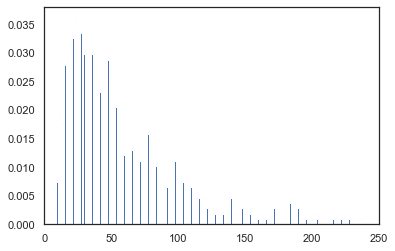

In [257]:
grid(2)

In [171]:
hist3,edge3=new_p(249)

In [126]:
#     return np.sum(p_hist)
new_p(249)

1.0000000000062002

In [51]:
print(js_divergence_scipy(p,new_p(249)))

0.0


     Grid_50_Histogram  Grid_50_Histogram_Edges
0         1.000000e-13                        0
1         1.000000e-13                        1
2         1.000000e-13                        2
3         1.000000e-13                        3
4         1.000000e-13                        4
..                 ...                      ...
244       1.000000e-13                      244
245       1.000000e-13                      245
246       1.000000e-13                      246
247       9.302326e-04                      247
248       1.000000e-13                      248

[249 rows x 2 columns]


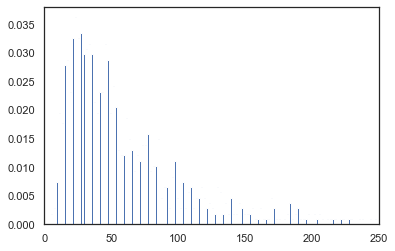

In [282]:
Grid_50_Histogram,Grid_50_Histogram_Edges=grid(2)
Grid_50=pd.DataFrame({'Grid_50_Histogram': Grid_50_Histogram, 'Grid_50_Histogram_Edges': Grid_50_Histogram_Edges})
print(Grid_50)

In [156]:
hist2,edge2=grid(2)

In [240]:
a=hist1[0:100]
b=a[np.where(a>0.001)]
c=len(b)
print(c)

100


In [242]:
a=hist2[0:100]
b=a[np.where(a>0.001)]
c=len(b)
print(c)

48


In [244]:
a=hist3[0:100]
b=a[np.where(a>0.001)]
c=len(b)
print(c)

88


In [241]:
a=hist1[100:250]
b=a[np.where(a>0.001)]
c=len(b)
print(c)

12


In [243]:
a=hist2[100:250]
b=a[np.where(a>0.001)]
c=len(b)
print(c)

38


In [245]:
a=hist3[100:250]
b=a[np.where(a>0.001)]
c=len(b)
print(c)

54


In [190]:
# c,d=grid(4)
# print(sum(c))
# sns.distplot(c,d) 
# plt.xlim(0, 250)
# plt.title("Grain Size Histogram")
# plt.xlabel('Grain Size')
# plt.ylabel('Frequency')

In [169]:
# print(len(grid(2)))

In [145]:
#     return sum(scaled_grid_count)
grid(4)

87017.0000000005

In [124]:
#     return np.sum(q_hist)
grid(4)

1.0000000000189002

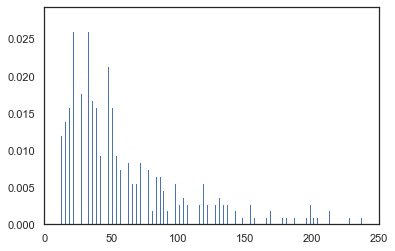

In [268]:
#grid 80%
fine_grid(5)

     Grid_80_Histogram  Grid_80_Histogram_Edges
0         1.000000e-13                        0
1         1.000000e-13                        1
2         1.000000e-13                        2
3         1.000000e-13                        3
4         1.000000e-13                        4
..                 ...                      ...
244       1.000000e-13                      244
245       1.000000e-13                      245
246       1.000000e-13                      246
247       1.000000e-13                      247
248       1.000000e-13                      248

[249 rows x 2 columns]


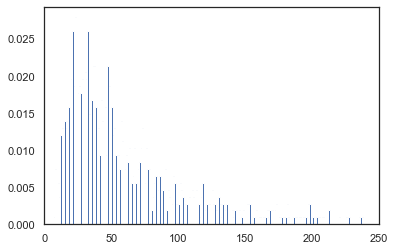

In [283]:
Grid_80_Histogram,Grid_80_Histogram_Edges=fine_grid(5)
Grid_80=pd.DataFrame({'Grid_80_Histogram': Grid_80_Histogram, 'Grid_80_Histogram_Edges': Grid_80_Histogram_Edges})
print(Grid_80)

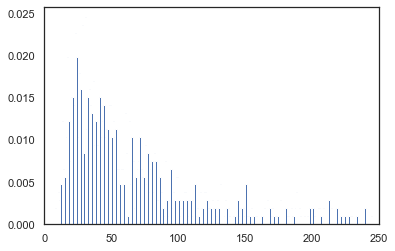

In [196]:
#actual histogram
new_p(249)

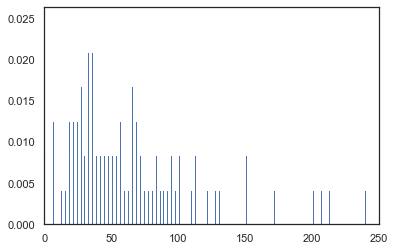

In [273]:
#window 20%
grain_rect_count(44.7)

In [44]:
def kl_divergence(p, q, binsize=249):
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(binsize))

def js_divergence(p, q, binsize=249):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m, binsize) + 0.5 * kl_divergence(q, m, binsize)

In [116]:
# #sums to one, good sign
# print(len(p_hist))
# print(len(p_bin_edges))
# print(np.sum(p_hist))

249
249
1.0000000000062002


In [34]:
# #if density doesn't work, just normalize by sum, bin size determined by 
# q_hist, q_bin_edges = np.histogram(random_mean(44000,10), bins=np.arange(250), density=True)
# q=q_hist
# q[q==0]=[0.0000000000001]
# #q_hist = np.append(q_hist, 0)
# #print(distance.jensenshannon(p_hist, q_hist))
# #sns.barplot(q_bin_edges, q_hist)

In [35]:
# plt.bar(q_bin_edges[:-1], q_hist, width=1, color=(1, 0, 0, 1))
# plt.xlim(0, 250)
# plt.show()
# #why is it denser? leads to lower divergence

In [36]:
# plt.bar(p_bin_edges[:-1], p_hist, width=1, color=(0, 0, 1, 0.3))
# plt.bar(q_bin_edges[:-1], q_hist, width=1, color=(1, 0, 0, 0.3))
# plt.xlim(0, 250)
# plt.show()

In [37]:
# #if density doesn't work, just normalize by sum, bin size determined by 
# q2_hist, q2_bin_edges = np.histogram(random(44000), bins=np.arange(250), density=True)
# q2=q2_hist
# q2[q2==0]=[0.0000000000001]
# #q_hist = np.append(q_hist, 0)
# #print(distance.jensenshannon(p_hist, q_hist))
# #sns.barplot(q_bin_edges, q_hist)
# plt.bar(q2_bin_edges[:-1], q2_hist, width=1, color=(1, 0, 0, 1))
# plt.xlim(0, 250)
# plt.show()

In [38]:
# k=hist_random_mean(44000, 10)
# k[k==0]=[0.0000000000001]
# #q_hist = np.append(q_hist, 0)
# #print(distance.jensenshannon(p_hist, q_hist))
# #sns.barplot(q_bin_edges, q_hist)
# print(js_divergence(p,k))
# plt.bar(q_bin_edges[:-1], k, width=1, color=(0, 1, 0, 1))
# plt.xlim(0, 250)
# plt.show()

In [39]:
# #x_max=250/87017
# print(bin_num)
# sns.distplot(random_mean(40000,10), hist=True, bins=249, kde=True)
# plt.xlim(0, 250)
# plt.title("Grain Size Histogram")
# plt.xlabel('Grain Size')
# plt.ylabel('Frequency')
# #identical to actual and vectorized

In [37]:
#quadrants

#top left
tld=js_divergence(new_p(249),grain_rect_count_3(50,50))
#top right
trd=js_divergence(new_p(249),grain_rect_count_2(50,50))
#bottom right
brd=js_divergence(grain_rect_count_4(50,50),new_p(249))
#bottom left
bld=js_divergence(grain_rect_count_1(50,50),new_p(249))

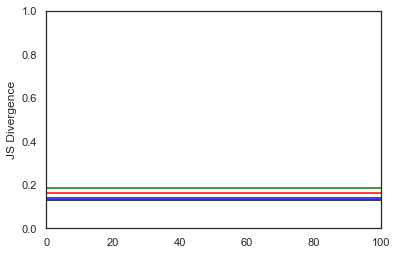

In [198]:
plt.xlim(0, 100)
plt.ylim(0, 1)
#plt.title('JS Divergence of Whole Dataset and Quadrants')
#plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#top left
plt.axhline(y=tld, color='red', linestyle='-',label='top left')
#top right
plt.axhline(y=trd, color='green', linestyle='-',label='top right')
#bottom right
plt.axhline(y=brd, color='black', linestyle='-',label='bottom right')
#bottom left
plt.axhline(y=bld, color='blue', linestyle='-',label='bottom left')

#window size vs divergence

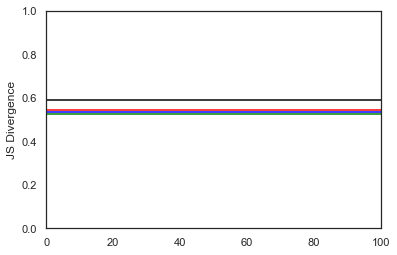

In [199]:
#grid shifts

#zero
zero=js_divergence(new_p(249),grid(4,start=0))
#one
one=js_divergence(new_p(249),grid(4,start=1))-0.02
#two
two=js_divergence(grid(4,start=2),new_p(249))-0.01
#three
three=js_divergence(grid(4,start=3),new_p(249))

plt.xlim(0, 100)
plt.ylim(0, 1)
#plt.title('JS Divergence of Whole Dataset and Quadrants')
#plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#top left
plt.axhline(y=zero, color='black', linestyle='-',label='zero')
#top right
plt.axhline(y=one, color='green', linestyle='-',label='one')
#bottom right
plt.axhline(y=two, color='blue', linestyle='-',label='two')
#bottom left
plt.axhline(y=three, color='red', linestyle='-',label='three')

In [40]:
#top_bottom_divergence
tbd=js_divergence(grain_rect_count_1(100,50),grain_rect_count_2(0,50))

#left_right_divergence
lrd=js_divergence(grain_rect_count_1(50,100),grain_rect_count_2(50,0))

#top right and bottom left divergence
trbl=js_divergence(grain_rect_count_1(50,50),grain_rect_count_2(50,50))

#top and whole
twd=js_divergence(new_p(249),grain_rect_count_2(0,50))

#bottom and whole
bwd=js_divergence(grain_rect_count_1(100,50),new_p(249))

#left and whole
lwd=js_divergence(grain_rect_count_1(50,100),new_p(249))

#right and whole
rwd=js_divergence(new_p(249),grain_rect_count_2(50,0))

#top right and whole
trw=js_divergence(new_p(249),grain_rect_count_2(50,50))

#bottom left and whole
blw=js_divergence(grain_rect_count_1(50,50),new_p(249))

In [48]:
random_divergence=[]
for i in range (1,87000,100):
    random_divergence.append(js_divergence(new_p(249), random(i)))

In [49]:
#x axis as percent
random_percent=[]

for i in range (1,87000,100):
    random_percent.append((i/87000)*100)

In [65]:
grid_percent=[]

for i in range(1,50,1):
     grid_percent.append(((87017/i)/87017)*100)

In [69]:
fine_grid_percent=[]

for i in range(2,100,1):
    fine_grid_percent.append(((87017-(87017/i))/87017)*100)

In [58]:
grid_divergence=[]

#past 50, values go out of range and oscillate
for i in range(1,50,1):
    grid_divergence.append(js_divergence(new_p(249),grid(i)))

In [52]:
fine_grid_divergence=[]
for i in range(2,100,1):
    fine_grid_divergence.append(js_divergence(new_p(249), fine_grid(i)))

In [258]:
window_percent=[]

for i in range(1,101,1):
    window_percent.append(i)

In [86]:
def random_mean(numSamples, numTrials):
    random_trials=[]
    for i in range(numTrials):
        random_trials.append(random(numSamples))
    mean=np.mean(random_trials, axis=0)
    return mean

In [87]:
random_mean_divergence=[]
for i in range (1,87000,100):
    random_mean_divergence.append(js_divergence(new_p(249), random_mean(i,10)))

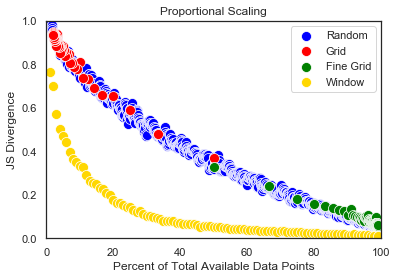

In [90]:
plt.xlim(0, 100)
plt.ylim(0, 1)
#plt.title('JS Divergence of Dataset and Randomly Sampled Subset')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')
plt.title('Proportional Scaling')

#SciPy, not log2
#sns.scatterplot(cc,aa,s=100, color="red", marker="+")

#mean
#sns.scatterplot(ee, dd, s=100, color="green", marker="+")

#custom, log2
#random
# sns.scatterplot(random_percent, random_divergence, s=100, color="blue", marker="o", label='random')
#random mean
sns.scatterplot(random_percent, random_mean_divergence, s=100, color="blue", marker="o", label='Random')
#grid
sns.scatterplot(grid_percent, grid_divergence, s=100, color="red", marker="o", label='Grid')
#fine grid
sns.scatterplot(fine_grid_percent, fine_grid_divergence, s=100, color="green", marker="o", label='Fine Grid')
#window
sns.scatterplot(window_percent, window_avg, s=100, color="gold", marker="o", label='Window')

# #window
# #top left
# plt.axhline(y=tld, color='purple', linestyle='-',label='top left')
# #top right
# plt.axhline(y=trd, color='purple', linestyle='-',label='top right')
# #bottom right
# plt.axhline(y=brd, color='purple', linestyle='-',label='bottom right')
# #bottom left
# plt.axhline(y=bld, color='purple', linestyle='-',label='bottom left')

# #grid
# #top left
# plt.axhline(y=zero, color='green', linestyle='-',label='zero')
# #top right
# plt.axhline(y=one, color='green', linestyle='-',label='one')
# #bottom right
# plt.axhline(y=two, color='green', linestyle='-',label='two')
# #bottom left
# plt.axhline(y=three, color='green', linestyle='-',label='three')


# #top and bottom rectangles
# plt.axhline(y=tbd, color='orange', linestyle='-')
# #right and left rectangles
# plt.axhline(y=lrd, color='yellow', linestyle='-')
# #top right and bottom left squares - smaller and higher divergence
# plt.axhline(y=trbl, color='red', linestyle='-')
# #top and whole
# plt.axhline(y=twd, color='orange', linestyle='-')
# #bottom and whole
# plt.axhline(y=bwd, color='orange', linestyle='-')
# #left and whole
# plt.axhline(y=lwd, color='yellow', linestyle='-')
# #right and whole
# plt.axhline(y=rwd, color='yellow', linestyle='-')
# #top right and whole
# plt.axhline(y=trw, color='red', linestyle='-')
# #bottom left and whole
# plt.axhline(y=blw, color='red', linestyle='-')
#could try from bottom left and top right if we want more data points

In [259]:
random_percent=[]
for i in range (1,87000,100):
    random_percent.append((i/87000)*100)

grid_percent=[]
for i in range(1,50,1):
     grid_percent.append(((87017/i)/87017)*100)

fine_grid_percent=[]
for i in range(2,100,1):
    fine_grid_percent.append(((87017-(87017/i))/87017)*100)

In [263]:
random_divergence=[]
for i in range (1,87000,100):
    random_divergence.append(hellinger_dot(new_p(249), random(i)))

grid_divergence=[]
for i in range(1,50,1):
    grid_divergence.append(hellinger_dot(new_p(249),grid(i)))

fine_grid_divergence=[]
for i in range(2,100,1):
    fine_grid_divergence.append(hellinger_dot(new_p(249), fine_grid(i)))

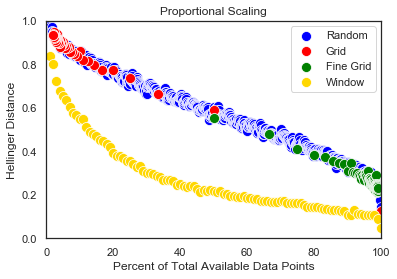

In [266]:
plt.xlim(0, 100)
plt.ylim(0, 1)
#plt.title('JS Divergence of Dataset and Randomly Sampled Subset')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('Hellinger Distance')
plt.title('Proportional Scaling')

#random
# sns.scatterplot(random_percent, random_divergence, s=100, color="blue", marker="o", label='random')
#random mean
sns.scatterplot(random_percent, random_divergence, s=100, color="blue", marker="o", label='Random')
#grid
sns.scatterplot(grid_percent, grid_divergence, s=100, color="red", marker="o", label='Grid')
#fine grid
sns.scatterplot(fine_grid_percent, fine_grid_divergence, s=100, color="green", marker="o", label='Fine Grid')
#window
sns.scatterplot(window_percent_two, h_window_avg, s=100, color="gold", marker="o", label='Window')

In [ ]:
#past 80, is it just fitting to peculiarities in the data? How much of this is due to edge grains?

In [120]:
# new_p(249)

In [118]:
print(js_divergence_scipy(new_p(249), grain_rect_count(sqrt(7*100))))

0.35911535394318883


In [177]:
#investigate
print(js_divergence_scipy(hist3, hist1))

0.7092245928692932


In [392]:
a,b=grain_rect_count(7)
sns.distplot(a,b) 
plt.xlim(0, 250)
plt.title("Grain Size Histogram")
plt.xlabel('Grain Size')
plt.ylabel('Frequency')

In [114]:
print(js_divergence_scipy(new_p(249),grid(2)))

0.3704346717011888


In [178]:
print(js_divergence_scipy(hist3, hist2))

0.3704346717011888


In [393]:
#still doesn't look right

c,d=grid(2)
print(sum(c))
sns.distplot(c,d) 
plt.xlim(0, 250)
plt.title("Grain Size Histogram")
plt.xlabel('Grain Size')
plt.ylabel('Frequency')

In [50]:
random_divergence_scipy=[]
for i in range (1,87000,100):
    random_divergence_scipy.append(js_divergence_scipy(new_p(249), random(i)))

In [116]:
grid_divergence_scipy=[]
for i in range(1,50,1):
    grid_divergence_scipy.append(js_divergence_scipy(new_p(249),grid(i)))

In [391]:
fine_grid_divergence_scipy=[]
for i in range(2,100,1):
    fine_grid_divergence_scipy.append(js_divergence_scipy(new_p(249), fine_grid(i)))

In [ ]:
window_divergence_scipy=[]
for i in range(2,100,1):
    window_divergence_scipy.append(js_divergence_scipy(new_p(249), grain_rect_count(sqrt(i*100))))

In [ ]:
random_divergence_scipy=[]
for i in range (1,87000,100):
    random_divergence_scipy.append(js_divergence_scipy(new_p(249), random(i)))

In [390]:
# plt.xlim(0, 100)
# plt.ylim(0, 1)
# #plt.title('JS Divergence of Dataset and Randomly Sampled Subset')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('JS Divergence')
# plt.title('Proportional Scaling')

# #SciPy, log2
# #random
# sns.scatterplot(random_percent, random_divergence_scipy, s=100, color="blue", marker="o", label='Random')
# #grid
# sns.scatterplot(grid_percent, grid_divergence_scipy, s=100, color="red", marker="o", label='Grid')
# #fine grid
# sns.scatterplot(fine_grid_percent, fine_grid_divergence_scipy, s=100, color="green", marker="o", label='Fine Grid')
# #window
# sns.scatterplot(window_percent_two, window_avg, s=100, color="gold", marker="o", label='Window')

# # #window
# # #top left
# # plt.axhline(y=tld, color='purple', linestyle='-',label='top left')
# # #top right
# # plt.axhline(y=trd, color='purple', linestyle='-',label='top right')
# # #bottom right
# # plt.axhline(y=brd, color='purple', linestyle='-',label='bottom right')
# # #bottom left
# # plt.axhline(y=bld, color='purple', linestyle='-',label='bottom left')

# # #grid
# # #top left
# # plt.axhline(y=zero, color='green', linestyle='-',label='zero')
# # #top right
# # plt.axhline(y=one, color='green', linestyle='-',label='one')
# # #bottom right
# # plt.axhline(y=two, color='green', linestyle='-',label='two')
# # #bottom left
# # plt.axhline(y=three, color='green', linestyle='-',label='three')

In [ ]:
#not a problem with the js divergence calculation!

In [16]:
window_percent_two=[]
for x in range (1,101,1):
    window_percent_two.append(x)

In [280]:
window_divergence_one=[]
for x in range (1,101,1):
    window_divergence_one.append(js_divergence_scipy(new_p(249), grain_rect_count_1(sqrt(x*100),sqrt(x*100))))

In [281]:
window_divergence_two=[]
for x in range (1,101,1):
    window_divergence_two.append(js_divergence_scipy(new_p(249), grain_rect_count_2(100-sqrt(x*100),100-sqrt(x*100))))

In [282]:
window_divergence_three=[]
for x in range (1,101,1):
    window_divergence_three.append(js_divergence_scipy(new_p(249), grain_rect_count_3(sqrt(x*100),100-sqrt(x*100))))

In [283]:
window_divergence_four=[]
for x in range (1,101,1):
    window_divergence_four.append(js_divergence_scipy(new_p(249), grain_rect_count_4(100-sqrt(x*100),sqrt(x*100))))

In [408]:
#top left
tld=js_divergence(new_p(249),grain_rect_count_3(50,50))
#top right
trd=js_divergence(new_p(249),grain_rect_count_2(50,50))
#bottom right
brd=js_divergence(grain_rect_count_4(50,50),new_p(249))
#bottom left
bld=js_divergence(grain_rect_count_1(50,50),new_p(249))

In [389]:
# plt.xlim(0, 100)
# plt.ylim(0, 1)
# plt.title('Window Divergences Compared')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('JS Divergence')

# #window one
# sns.scatterplot(window_percent_two, window_divergence_one, s=100, color="red", marker="o", label='Window One')
# # #bottom left
# # plt.axhline(y=bld, color='red', linestyle='-',label='bottom left')

# #window two
# sns.scatterplot(window_percent_two, window_divergence_two, s=100, color="green", marker="o", label='Window Two')
# # #top right
# # plt.axhline(y=trd, color='green', linestyle='-',label='top right')

# #window three
# sns.scatterplot(window_percent_two, window_divergence_three, s=100, color="blue", marker="o", label='Window Three')
# # #top left
# # plt.axhline(y=tld, color='blue', linestyle='-',label='top left')

# #window four
# sns.scatterplot(window_percent_two, window_divergence_four, s=100, color="purple", marker="o", label='Window Four')
# # #bottom right
# # plt.axhline(y=brd, color='purple', linestyle='-',label='bottom right')

# #Voronoi
# sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="gold", marker="o", label='Voronoi Random')

In [388]:
# #window avg
# window_array=np.array([window_divergence_one,window_divergence_two,window_divergence_three,window_divergence_four])
# # print(window_array)
# window_avg=(window_array.sum(axis=0))/4
# sns.scatterplot(window_percent_two, window_avg, s=100, color="blue", marker="o", label='Window Average')

In [85]:
window_percent_two=[]
for x in range (1,101,1):
    window_percent_two.append(x)

In [ ]:
#
window_percent_two=[]
for x in range (1,101,1):
    window_percent_two.append(x)

window_divergence_one=[]
for x in range (1,101,1):
    window_divergence_one.append(hellinger_dot(new_p(249), grain_rect_count_1(sqrt(x*100),sqrt(x*100))))

window_divergence_two=[]
for x in range (1,101,1):
    window_divergence_two.append(hellinger_dot(new_p(249), grain_rect_count_2(100-sqrt(x*100),100-sqrt(x*100))))

window_divergence_three=[]
for x in range (1,101,1):
    window_divergence_three.append(hellinger_dot(new_p(249), grain_rect_count_3(sqrt(x*100),100-sqrt(x*100))))

window_divergence_four=[]
for x in range (1,101,1):
    window_divergence_four.append(hellinger_dot(new_p(249), grain_rect_count_4(100-sqrt(x*100),sqrt(x*100))))

plt.xlim(0, 100)
plt.ylim(0, 1)
plt.title('Window Divergences Compared')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#window one
sns.scatterplot(window_percent_two, window_divergence_one, s=100, color="red", marker="o", label='Window One')
# #bottom left
# plt.axhline(y=bld, color='red', linestyle='-',label='bottom left')

#window two
sns.scatterplot(window_percent_two, window_divergence_two, s=100, color="green", marker="o", label='Window Two')
# #top right
# plt.axhline(y=trd, color='green', linestyle='-',label='top right')

#window three
sns.scatterplot(window_percent_two, window_divergence_three, s=100, color="blue", marker="o", label='Window Three')
# #top left
# plt.axhline(y=tld, color='blue', linestyle='-',label='top left')

#window four
sns.scatterplot(window_percent_two, window_divergence_four, s=100, color="purple", marker="o", label='Window Four')
# #bottom right
# plt.axhline(y=brd, color='purple', linestyle='-',label='bottom right')

#window avg
window_array=np.array([window_divergence_one,window_divergence_two,window_divergence_three,window_divergence_four])
h_window_avg=(window_array.sum(axis=0))/4

sns.scatterplot(window_percent_two, window_avg, s=100, color="blue", marker="o", label='Window Average')

In [ ]:
#visually, top right of graph looks different

In [278]:
voronoi_random_divergence=[]
for x in range (1000,87000,1000):
#     print(x)
    voronoi_random_divergence.append(js_divergence_scipy(new_p(249), random_vor(x)))

In [54]:
#up to 20 needs finer percent
voronoi_random_divergence_copy=np.copy(voronoi_random_divergence)

In [ ]:
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.title('Scaled vs Voronoi Random Sampling')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#Voronoi
sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="blue", marker="o", label='Voronoi')
#Scaled
sns.scatterplot(random_percent, random_divergence_scipy, s=100, color="red", marker="o", label='Scaled')

In [387]:
# plt.xlim(0, 100)
# plt.ylim(0, 0.95)
# plt.title('Voronoi Scaling')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('JS Divergence')

# #Voronoi
# sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="blue", marker="o", label='Random')
# # #Scaled
# # # sns.scatterplot(random_percent, random_divergence_scipy, s=100, color="blue", marker="+", label='Scaled Random')
# # #Voronoi
# sns.scatterplot(vor_grid_percent, voronoi_grid_divergence, s=100, color="red", marker="o", label='Grid')
# # #Scaled
# # # sns.scatterplot(grid_percent, grid_divergence_scipy, s=100, color="red", marker="+", label='Scaled Grid')
# # #Voronoi
# sns.scatterplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, s=100, color="green", marker="o", label='Fine Grid')
# # #Scaled
# # # sns.scatterplot(fine_grid_percent, fine_grid_divergence_scipy, s=100, color="green", marker="+", label='Scaled Fine Grid')
# # #Window 
# sns.scatterplot(window_percent_two, window_avg, s=100, color="gold", marker="o", label='Window')

In [41]:
vor_grid_percent=[]
for i in range(1,25,1):
    vor_grid_percent.append(((87017/i)/87017)*100)
    
vor_fine_grid_percent=[]
for i in range(2,25,1):
    vor_fine_grid_percent.append(((87017-(87017/i))/87017)*100)
    
vor_random_percent=[]
for i in range (100,25000,1000):
    vor_random_percent.append((i/87000)*100)

In [40]:
vor_random_percent_2=[]
for i in range (100,25000,1000):
    vor_random_percent_2.append((i/87000)*100)

In [32]:
window_percent=[]
for x in range (1,26,1):
    window_percent.append(x)

In [38]:
voronoi_grid_divergence=[]
for x in range(1,25,1):
    voronoi_grid_divergence.append(js_divergence_scipy(k3, grid_vor(x)))

In [402]:
voronoi_fine_grid_divergence=[]
for x in range(2,25,1):
    voronoi_fine_grid_divergence.append(js_divergence_scipy(k3, fine_grid_vor(x)))

In [35]:
window_divergence_vor=[]
for x in range (1,26,1):
    window_divergence_vor.append(js_divergence_scipy(k3, grain_rect_count_vor(sqrt(x*100))))

In [44]:
voronoi_random_divergence=[]
for x in range (100,25000,1000):
    voronoi_random_divergence.append(js_divergence_scipy(k3, random_vor(x)))

In [414]:
voronoi_random_divergence_replace=[]
for x in range (100,87000,1000):
    try:
        voronoi_random_divergence_replace.append(js_divergence_scipy(k3, random_vor(x,replacement=True)))
    except:
        print('Exception at x = '+str(x))

In [ ]:
vor_jitter_percent=[]
for x in range(1,25,1):
    vor_jitter_percent.append(((87017/x)/87017)*100)

In [243]:
voronoi_jitter_divergence_2=[]
for x in range(1,25,1):
    voronoi_jitter_divergence_2.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,100)))

In [244]:
voronoi_jitter_divergence_3=[]
for x in range(1,25,1):
    voronoi_jitter_divergence_3.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,50)))

In [245]:
voronoi_jitter_divergence_4=[]
for x in range(1,25,1):
    voronoi_jitter_divergence_4.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,25)))

In [246]:
voronoi_jitter_divergence_5=[]
for x in range(1,25,1):
    voronoi_jitter_divergence_5.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,12)))

In [247]:
voronoi_jitter_divergence_6=[]
for x in range(1,25,1):
    voronoi_jitter_divergence_6.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,6)))

In [248]:
voronoi_jitter_divergence_7=[]
for x in range(1,25,1):
    voronoi_jitter_divergence_7.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,3)))

In [266]:
voronoi_jitter_divergence_8=[]
for x in range(1,25,1):
    voronoi_jitter_divergence_8.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,2)))

In [264]:
voronoi_jitter_divergence_9=[]
for x in range(1,25,1):
    try:
        voronoi_jitter_divergence_9.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,1)))
    except:
        print('Exception at x = '+str(x))

Exception at x = 13
Exception at x = 23


In [280]:
voronoi_jitter_divergence_9.remove(0)

In [273]:
vor_jitter_percent_2=[]
for x in range(1,25,1):
    vor_jitter_percent_2.append(((87017/x)/87017)*100)
    
vor_jitter_percent_2.remove(vor_jitter_percent_2[12])
vor_jitter_percent_2.remove(vor_jitter_percent_2[22])

In [263]:
voronoi_jitter_divergence_1=[]
for x in range(1,25,1):
    voronoi_jitter_divergence_1.append(js_divergence_scipy(k3, jitter_2(x,coords_and_grains_copy,0)))

In [249]:
%store voronoi_jitter_divergence_8
%store voronoi_jitter_divergence_9

Stored 'voronoi_jitter_divergence_8' (list)
Stored 'voronoi_jitter_divergence_9' (list)


In [7]:
%store -r

In [459]:
# plt.xlim(0, 100)
# plt.ylim(0, 1)
# plt.title('Voronoi Scaling')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('JS Divergence')

# #Random
# # sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="blue", marker="o", label='Random')
# sns.lineplot(vor_random_percent, voronoi_random_divergence, color="blue", label='Random, No Replacement')
# #Random wtih duplicates
# # # sns.scatterplot(vor_random_percent_2, voronoi_random_divergence_replace, s=100, color="blue", marker="o", label='Random, Duplicates')
# # sns.lineplot(vor_random_percent_2, voronoi_random_divergence_replace, color="blue", label='Random, Replacement')
# #Grid
# # sns.scatterplot(vor_grid_percent, voronoi_grid_divergence, s=100, color="red", marker="o", label='Grid')
# sns.lineplot(vor_grid_percent, voronoi_grid_divergence, color="red", label='Grid')
# #Fine Grid
# # # sns.scatterplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, s=100, color="red", marker="o", label='Grid')
# sns.lineplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, color="red", label='Fine Grid')
# # # #Jitter One
# # # sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_1, s=100, color="purple", marker="o", label='Jitter=0')
# # sns.lineplot(vor_jitter_percent, voronoi_jitter_divergence_1, color="purple", label='Jitter=0')
# # # #Jitter 9
# # # sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_9, s=100, color="purple", marker="o", label='Jitter=1')
# # sns.lineplot(vor_jitter_percent_2, voronoi_jitter_divergence_9, color="purple", label='Jitter=1')
# # # #Jitter 8
# # # sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_8, s=100, color="purple", marker="o", label='Jitter=2')
# # # sns.lineplot(vor_jitter_percent, voronoi_jitter_divergence_8, color="purple", label='Jitter=2')

In [253]:
%store voronoi_random_divergence_replace
%store voronoi_jitter_divergence_1
%store voronoi_jitter_divergence_8
%store voronoi_jitter_divergence_9

Stored 'voronoi_random_divergence_replace' (list)
Stored 'voronoi_jitter_divergence_1' (list)
Stored 'voronoi_jitter_divergence_8' (list)
Stored 'voronoi_jitter_divergence_9' (list)


In [46]:
#add divergence at 100%
vor_random_percent.append(100)
# vor_random_percent_2.append(100)
voronoi_random_divergence.append(0)
# voronoi_random_divergence_replace.append(0.08420902459423057)

window_percent.append(0)
window_divergence_vor.append(1)

vor_grid_percent.append(0)
voronoi_grid_divergence.append(1)

vor_grid_percent.append(1)
voronoi_grid_divergence.append(0.7380891294936394)

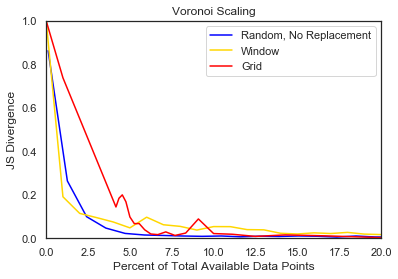

In [47]:
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.title('Voronoi Scaling')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#Random
# sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="blue", marker="o", label='Random')
sns.lineplot(vor_random_percent, voronoi_random_divergence, color="blue", label='Random, No Replacement')
#Random wtih duplicates
# sns.scatterplot(vor_random_percent_2, voronoi_random_divergence_replace, s=100, color="purple", marker="o", label='Random, Duplicates')
#Window 
# sns.scatterplot(window_percent, window_divergence_vor, s=100, color="gold", marker="o", label='Window')
sns.lineplot(window_percent, window_divergence_vor, color="gold", label='Window')
#Grid
# sns.scatterplot(vor_grid_percent, voronoi_grid_divergence, s=100, color="red", marker="o", label='Grid')
sns.lineplot(vor_grid_percent, voronoi_grid_divergence, color="red", label='Grid')
#Fine Grid
# sns.scatterplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, s=100, color="green", marker="o", label='Fine Grid')
# sns.lineplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, color="green", label='Fine Grid')

In [ ]:
%store
%store
%store

In [37]:
# %store voronoi_random_divergence
# %store window_divergence_vor
# %store voronoi_grid_divergence
# %store voronoi_fine_grid_divergence

In [169]:
print(js_divergence_scipy(k2,random_vor(87017,replacement=True)))

0.08420902459423057


In [193]:
print(js_divergence_scipy(k2,jitter_2(1,coords_and_grains_copy,0)))

0.0


In [55]:
# print(js_divergence_scipy(k2,random_vor(87017)))
# print(js_divergence_scipy(k2,grid_vor(1)))

0.0


In [180]:
%store window_divergence_vor
%store voronoi_random_divergence
%store voronoi_grid_divergence
%store voronoi_fine_grid_divergence
%store voronoi_random_divergence_replace

Stored 'window_divergence_vor' (list)
Stored 'voronoi_random_divergence' (list)
Stored 'voronoi_grid_divergence' (list)
Stored 'voronoi_fine_grid_divergence' (list)
Stored 'voronoi_random_divergence_replace' (list)


In [31]:
def jitter(array,num_boxes,percent,binsize=249,hist=True,mean_var=False): 
    
    #array to hold (un)sampled points
    sampled=np.zeros((len(raw_data),1))
    array=np.concatenate((array,sampled.reshape(-1,1)),axis=1)
    
    #row_IDs to access unsampled points
    row_IDs=np.arange(0,len(raw_data))
    array=np.concatenate((array,row_IDs.reshape(-1,1)),axis=1)
    
    #total number of points to randomly sample
    num_points=len(array)*(percent/100)
    
    #number of points to randomly sample in each box
    num_box_points=int(num_points/num_boxes)
    
    #a=l^2 (i.e. 22, 4x4 etc)
    square_dim=np.sqrt(num_boxes)
    
    #side length of the square
    x_total_side_len=float(max(raw_data[:,3]))
    y_total_side_len=float(max(raw_data[:,4]))
    
    #side length of each jitter square
    x_side_len=x_total_side_len/square_dim
    y_side_len=y_total_side_len/square_dim
    
    #number of sides to iterate for loop
    num_sides=int(round(x_total_side_len/x_side_len))
    
    #create array to hold the result
    jittered_array=np.zeros(array.shape[1])
    
    num_points_lost=0
    
    #break down into gridded sample 
    lower_x_bound=0
    lower_y_bound=0
    
    new_x_side_len=x_side_len
    for x in range(0,num_sides,1): 
        x_slice=array[np.where((lower_x_bound<=array[:,3]) & (array[:,3]<new_x_side_len))]
#         print(str(lower_x_bound)+', '+str(new_x_side_len))
        lower_x_bound+=x_side_len
        new_x_side_len+=x_side_len
        
#         print(len(x_slice))
        
        lower_y_bound=0
        new_y_side_len=y_side_len
        for y in range(0,num_sides,1):
            y_slice=array[np.where((lower_y_bound<=x_slice[:,4]) & (x_slice[:,4]<new_y_side_len))]
#             print(str(lower_y_bound)+', '+str(new_y_side_len))
            lower_y_bound+=y_side_len
            new_y_side_len+=y_side_len
        
#             print(len(y_slice))
            
            #randomly sample points in box, box might have less than avg number of points, throwing an exception
            try:
                random_boxed_points=y_slice[np.random.choice(y_slice.shape[0], num_box_points, replace=False), :]
            #if exception, just use all of the points
            except:
                random_boxed_points=y_slice
                num_points_lost+=num_box_points-len(y_slice)

            array[[y_slice[:,7].astype(int)],6]=1
            jittered_array=np.vstack((jittered_array,random_boxed_points))
            
    #delete the placeholder first row of the answer     
    jittered_array=np.delete(jittered_array, 0, 0)
    
    #randomly sample the unsampled points (due to rounding errors, irregularities, etc)
    unsampled=array[np.where(array[:,6]!=1)]
    unsampled=unsampled[np.random.choice(unsampled.shape[0], num_points_lost, replace=False), :]
    jittered_array=np.vstack((jittered_array,unsampled))

#     print(len(jittered_array))








    
    #turn into prob vec
    jitter_coords=jittered_array[:,[3,4]]
    jitter_grain_IDs=jittered_array[:,5]
    
    #get areas
    vol=voronoi_volumes(jitter_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((jitter_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #double edge grains
    row_ID=0
    for row in unique_grain_IDs_and_total_areas:
        #if the grain ID is an edge
        if np.isin(row[0],edge_grains[:,0]):
            #double the total grain area
            unique_grain_IDs_and_total_areas[row_ID,1]*=2
        row_ID+=1
        
    #return count for hist
    count = unique_grain_IDs_and_total_areas[:,1]
     
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    if hist==True:
        return q
    
    if mean_var==True:
        mean=np.mean(count)
        var=np.var(count)
        return mean, var

In [112]:
js_divergence_scipy(k2,jitter(raw_data,1,100))

0.0

In [114]:
#Create curves using different box sizes (with randomly sampled points within)
#Box size of point dim should be same as grid, one box (total of len(array) boxes) should be like random

vor_jitter_percent=[]
for x in range(1,101,2):
    vor_jitter_percent.append(x)

voronoi_jitter_divergence_1=[]
for x in range(1,101,2):
    voronoi_jitter_divergence_1.append(js_divergence_scipy(k2, jitter(raw_data,1,x)))

voronoi_jitter_divergence_16=[]
for x in range(1,101,2):
    voronoi_jitter_divergence_16.append(js_divergence_scipy(k2, jitter(raw_data,16,x)))

voronoi_jitter_divergence_484=[]
for x in range(1,101,2):
    voronoi_jitter_divergence_484.append(js_divergence_scipy(k2, jitter(raw_data,484,x)))

voronoi_jitter_divergence_3136=[]
for x in range(1,101,3):
    voronoi_jitter_divergence_3136.append(js_divergence_scipy(k2, jitter(raw_data,3136,x)))

voronoi_jitter_divergence_12544=[]
for x in range(1,101,3):
    voronoi_jitter_divergence_12544.append(js_divergence_scipy(k2, jitter(raw_data,12544,x)))

voronoi_jitter_divergence_86436=[]
for x in range(1,101,4):
    voronoi_jitter_divergence_86436.append(js_divergence_scipy(k2, jitter(raw_data,86436,x)))

%store voronoi_jitter_divergence_1
%store voronoi_jitter_divergence_16
%store voronoi_jitter_divergence_484
%store voronoi_jitter_divergence_3136
%store voronoi_jitter_divergence_12544
%store voronoi_jitter_divergence_86436

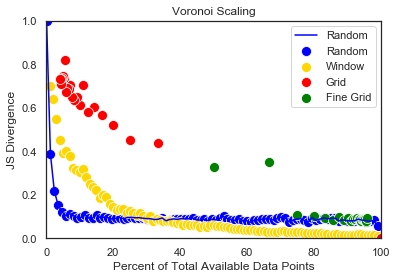

In [172]:
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.title('Voronoi Scaling')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#Random
sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="blue", marker="o", label='Random')
# sns.lineplot(vor_random_percent, voronoi_random_divergence, color="blue", label='Random')
#Random wtih duplicates
sns.scatterplot(vor_random_percent, voronoi_random_divergence, s=100, color="blue", marker="o", label='Random')
#Window 
sns.scatterplot(window_percent, window_divergence_vor, s=100, color="gold", marker="o", label='Window')
#Grid
sns.scatterplot(vor_grid_percent, voronoi_grid_divergence, s=100, color="red", marker="o", label='Grid')
#Fine Grid
sns.scatterplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, s=100, color="green", marker="o", label='Fine Grid')
#Jitter (1 subsquare)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_1, s=100, color="pink", marker="o", label='Jitter 1')
#Jitter (16 subsquares)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_16, s=100, color="pink", marker="o", label='Jitter 16')
#Jitter (484 subsquares)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_484, s=100, color="pink", marker="o", label='Jitter 484')
# #Jitter (3136 subsquares)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_3136, s=100, color="pink", marker="o", label='Jitter 3136')
# #Jitter (12544 subsquares)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_12544, s=100, color="pink", marker="o", label='Jitter 12544')
# #Jitter (86436 subsquares)
# sns.scatterplot(vor_jitter_percent, voronoi_jitter_divergence_86436, s=100, color="pink", marker="o", label='Jitter 86436')

In [147]:
print(js_divergence_scipy(k2, jitter(raw_data,1,100)))

0.0


In [149]:
print(js_divergence_scipy(k2, jitter(raw_data,4,100)))

0.3010835118414603


In [150]:
print(js_divergence_scipy(k2, jitter(raw_data,16,100)))

0.3418104912041595


In [151]:
print(js_divergence_scipy(k2, jitter(raw_data,484,100)))

0.1639514431749807


In [152]:
print(js_divergence_scipy(k2, jitter(raw_data,3136,100)))

0.14827708897241654


In [153]:
print(js_divergence_scipy(k2, jitter(raw_data,12544,100)))

0.12874646711313104


In [154]:
print(js_divergence_scipy(k2, jitter(raw_data,86436,100)))

0.09481561650215983


In [ ]:
#no edge scaling

In [410]:
voronoi_random_divergence_2=[]
for x in range (100,87000,1000):
#     print(x)
    voronoi_random_divergence_2.append(js_divergence_scipy(k2, random_vor(x)))

In [411]:
window_divergence_vor_2=[]
for x in range (1,101,3):
    window_divergence_vor_2.append(js_divergence_scipy(k2, grain_rect_count_vor(sqrt(x*100))))

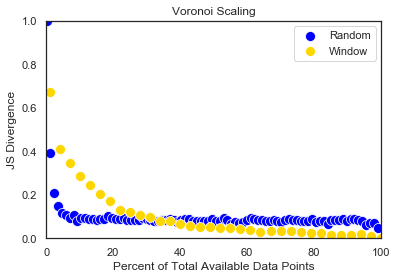

In [414]:
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.title('Voronoi Scaling')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#Voronoi
sns.scatterplot(vor_random_percent, voronoi_random_divergence_2, s=100, color="blue", marker="o", label='Random')
# #Window 
sns.scatterplot(window_percent_two, window_divergence_vor_2, s=100, color="gold", marker="o", label='Window')
#Grid
# sns.scatterplot(vor_grid_percent, voronoi_grid_divergence, s=100, color="red", marker="o", label='Grid')
#Fine Grid
# sns.scatterplot(vor_fine_grid_percent, voronoi_fine_grid_divergence, s=100, color="green", marker="o", label='Fine Grid')

In [408]:
print(js_divergence_scipy(k2,random_vor(87017)))

0.0


In [409]:
print(js_divergence_scipy(k2,grain_rect_count_vor(100)))

0.0


In [826]:
# p_hist, p_bin_edges = np.histogram(count, bins=np.arange(249), density=True)
# p_hist = np.append(p_hist, 0)
# p_hist[p_hist==0]=[0.0000000000001]
# p=p_hist
# print(js_divergence(p,random(44000,249)))

In [827]:
# binsize=50000

# p_hist, p_bin_edges = np.histogram(count, bins=np.arange(binsize), density=True)
# p_hist = np.append(p_hist, 0)
# p_hist[p_hist==0]=[0.0000000000001]
# p=p_hist
# print(js_divergence(p,random(44000,binsize)))

In [828]:
# tandom_divergence=[]
# for i in range (1,87000,100):
#     tandom_divergence.append(js_divergence(p, random(i,binsize)))
    
# print(len(tandom_divergence))

In [37]:
def divergence_graph(binsize):
    p=new_p(binsize)

    random_divergence=[]
    for i in range (1,87000,100):
        random_divergence.append(js_divergence(p, random(i,binsize), binsize))
    
    grid_divergence=[]
    for i in range(1,50,1):
        grid_divergence.append(js_divergence(p,grid(i,binsize), binsize))
    
    fine_grid_divergence=[]
    for i in range(2,100,1):
        fine_grid_divergence.append(js_divergence(p, fine_grid(i,binsize), binsize))
    
    #plot
    plt.xlim(0, 100)
    plt.ylim(0, 1)
    #plt.title('JS Divergence of Dataset and Randomly Sampled Subset')
    plt.xlabel('Percent of Total Available Data Points')
    plt.ylabel('JS Divergence')

    #random
    sns.scatterplot(random_percent, random_divergence, s=100, color="purple", marker="o")
    #grid
    sns.scatterplot(grid_percent, grid_divergence, s=100, color="green", marker="o")
    #fine grid
    sns.scatterplot(fine_grid_percent, fine_grid_divergence, s=100, color="blue", marker="o")
    #window
    sns.scatterplot(window_percent, window_divergence_scipy, s=100, color="purple", marker="o", label='window')

    #top and bottom rectangles
    plt.axhline(y=tbd, color='orange', linestyle='-')
    #right and left rectangles
    plt.axhline(y=lrd, color='yellow', linestyle='-')
    #top right and bottom left squares - smaller and higher divergence
    plt.axhline(y=trbl, color='red', linestyle='-')
    #could try from bottom left and top right if we want more data points

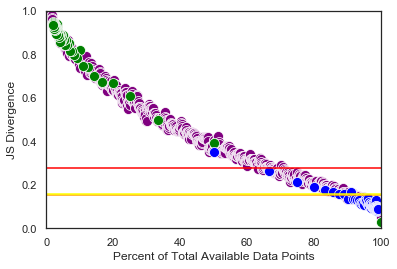

In [873]:
divergence_graph(10000)

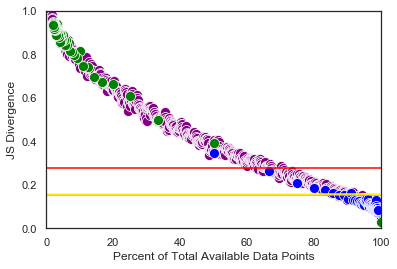

In [874]:
divergence_graph(1000)

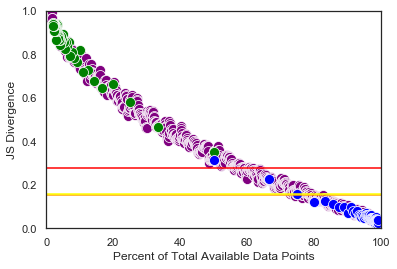

In [875]:
divergence_graph(100)

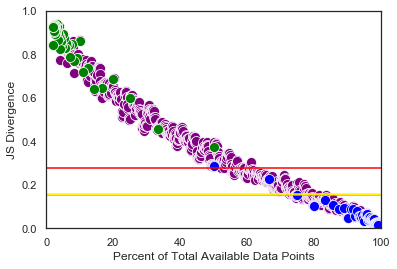

In [877]:
divergence_graph(50)

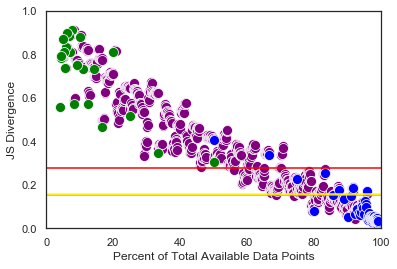

In [878]:
divergence_graph(25)

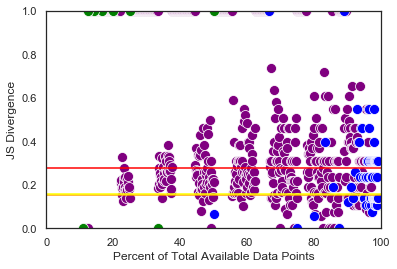

In [876]:
divergence_graph(10)

In [840]:
print(len(random_percent))
print(len(random_mean_divergence))

870
870


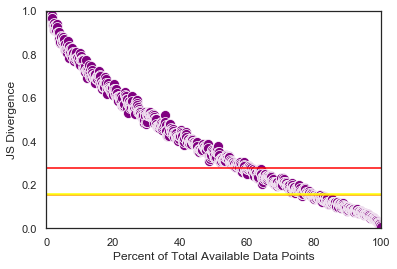

In [841]:
#function means

plt.xlim(0, 100)
plt.ylim(0, 1)
#plt.title('JS Divergence of Dataset and Randomly Sampled Subset')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#custom, log2
#random mean
sns.scatterplot(random_percent, random_mean_divergence, s=100, color="purple", marker="o")
# #grid mean
# sns.scatterplot(grid_percent, grid_divergence, s=100, color="green", marker="o")
# #fine grid mean
# sns.scatterplot(fine_grid_percent, fine_grid_divergence, s=100, color="blue", marker="o")

#top and bottom rectangles
plt.axhline(y=tbd, color='orange', linestyle='-')
#right and left rectangles
plt.axhline(y=lrd, color='yellow', linestyle='-')
#top right and bottom left squares - smaller and higher divergence
plt.axhline(y=trbl, color='red', linestyle='-')
#could try from bottom left and top right if we want more data points

In [ ]:
#implement grid/finegrid mean

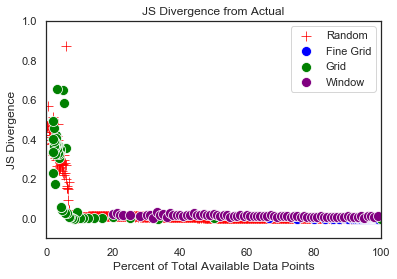

In [76]:
plt.xlim(0, 100)
plt.ylim(-0.1, 1)
#plt.title('JS Divergence of Dataset and Grid Sampled Subset')
plt.title('JS Divergence from Actual')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')
sns.scatterplot(cc, bb, s=100, color="red", marker="+", label='Random')
sns.scatterplot(www, yyy, s=100, color="blue", marker="o", label='Fine Grid')
sns.scatterplot(ww, yy, s=100, color="green", marker="o", label='Grid')
sns.scatterplot(x4, y4, s=100, color="purple", marker="o", label='Window')

In [758]:
# def grid_mean(res, numTrials):
#     random_trials=[]
#     start=0
#     for i in range(numTrials):
#         random_trials.append(grid(res))
#         start+=1
#     mean=sum(random_trials)/len(random_trials)
#     return mean

In [759]:
# def fine_grid_mean(res, numTrials):
#     random_trials=[]
#     start=0
#     for i in range(numTrials):
#         random_trials.append(fine_grid(res))
#         start+=1
#     mean=sum(random_trials)/len(random_trials)
#     return mean

In [760]:
# aa=[]
# bb=[]

# for i in range(1,85000,100):
#     aa.append(i)
#     bb.append(js_divergence(t,random_mean(i,10)))

In [761]:
# #histogram
# xyz=[]
# p=probability_vector
# for i in range(1,85000,100):
#     q=random(i)
#     xyz.append(distance.jensenshannon(p, q))

In [762]:
# plt.xlim(0, 100)
# plt.ylim(0, 1)
# #plt.title('JS Divergence of Dataset and Grid Sampled Subset')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('JS Divergence')
# sns.scatterplot(ww, yy, s=200, color="green", marker="+")
# #note: 80000/1000=80

In [763]:
# xxx=[]
# yyy=[]
# zzz=[]
# for i in range(2,100,1):
#     xxx.append(i)
#     yyy.append(js_divergence(t,fine_grid_mean(i,10)))
#     zzz.append(87017-(87017/i))

In [764]:
#     random_prob_vec=scaled_random_count/(np.sum(scaled_random_count))    
#     #make sure arrays are the same length, maybe try ones
#     t=len(ID)-len(random_prob_vec)
#     print(len(ID))
#     print(len(random_prob_vec))
#     print(t)
#     print(type(random_prob_vec))
#     for zero in range(0,t):
#         np.append(random_prob_vec, 0)
#     #np.pad(random_prob_vec, pad_width=(0, t), mode='constant')
#     print(len(random_prob_vec))

In [765]:
# plt.xlim(0, 100)
# plt.ylim(-0.1, 1)
# #plt.title('JS Divergence of Dataset and Grid Sampled Subset')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('JS Divergence')
# sns.scatterplot(www, yyy, s=200, color="blue", marker="+")

In [757]:
# sample=1000
# #print(random(sample))
# print(len(random(sample)))
# print(len(probability_vector))
# p=probability_vector
# q=random(sample)
# print(distance.jensenshannon(p, q))
# #where to stuff with zeroes?, start with large array of zeroes then add count, does index matter?, use hists to see if it alters

In [560]:
# def random_mean(numSamples, numTrials):
#     random_trials=[]
#     for i in range(numTrials):
#          random_trials.append(random(numSamples))
#     mean=np.mean(random_trials, axis=0)
#     return mean

In [583]:
# print(count)
# # count[0]*=2
# # print(count)
# # print(count[1113])
# # x=np.where(count == 12033)
# # print(int(x[0]))

In [450]:
# #probability vectorized histogram
# x_max=250/87017
# print(bin_num)
# sns.distplot(probability_vector, hist=True, bins=250, kde=True)
# plt.xlim(0, x_max)
# plt.title("Grain Size Histogram")
# plt.xlabel('Grain Size')
# plt.ylabel('Frequency')

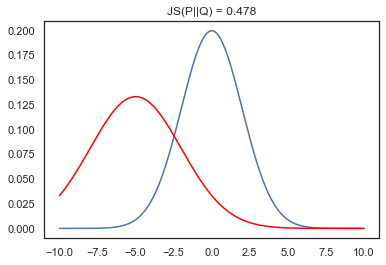

In [176]:
x = np.arange(-10, 10, 0.001)
p = norm.pdf(x, 0, 2)
x2 = np.arange(-5, 15, 0.001)
q = norm.pdf(x2, 0, 3)
plt.title('JS(P||Q) = %1.3f' % js_divergence_scipy(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red')

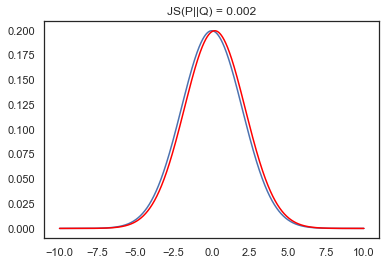

In [177]:
x = np.arange(-10, 10, 0.001)
p = norm.pdf(x, 0, 2)
q = norm.pdf(x, 0.2, 2)
plt.title('JS(P||Q) = %1.3f' % js_divergence_scipy(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red')

In [40]:
#load data
raw_data = np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8))
raw_data_copy=np.copy(raw_data)

In [41]:
a=sqrt(0.75)

#12 hexagonal close-packed crystal symmetry operators
op25=np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
op26=np.array([[-0.5, a, 0],[-a, -0.5, 0],[0, 0, 1]])
op27=np.array([[-0.5, -a, 0],[a, -0.5, 0],[0, 0, 1]])
op28=np.array([[0.5, a, 0],[-a, 0.5, 0],[0, 0, 1]])
op29=np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]])
op30=np.array([[0.5, -a, 0],[a, 0.5, 0],[0, 0, 1]])
op31=np.array([[-0.5, -a, 0],[-a, 0.5, 0],[0, 0, -1]])
op32=np.array([[1, 0, 0],[0, -1, 0],[0, 0, -1]])
op33=np.array([[-0.5, a, 0],[a, 0.5, 0],[0, 0, -1]])
op34=np.array([[0.5, a, 0],[a, -0.5, 0],[0, 0, -1]])
op35=np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]])
op36=np.array([[0.5, -a, 0],[-a, -0.5, 0],[0, 0, -1]])

op25,op26,op27,op28,op29,op30,op31,op32,op33,op34,op35,op36

#list of hexagonal sym ops
hex_sym_ops=[op25,op26,op27,op28,op29,op30,op31,op32,op33,op34,op35,op36]

In [42]:
#input is an array in radians as follows euler=[angle_one,angle_two,angle_three]
def misorientation(euler_one, euler_two,sym_op):
    #orientation matrices
    g_one=np.array([[((math.cos(euler_one[0]))*(math.cos(euler_one[2]))-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[0]))*(math.cos(euler_one[2]))+(math.cos(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[2]))*(math.sin(euler_one[1])))],
                [(-(math.cos(euler_one[0]))*(math.sin(euler_one[2]))-(math.sin(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),(-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))+(math.cos(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),((math.cos(euler_one[2]))*(math.sin(euler_one[1])))],
                [((math.sin(euler_one[0]))*(math.sin(euler_one[1]))),(-(math.cos(euler_one[0]))*(math.sin(euler_one[1]))),(math.cos(euler_one[1]))]        
                ])
   
    #euler_two
    g_two=np.array([[((math.cos(euler_two[0]))*(math.cos(euler_two[2]))-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[0]))*(math.cos(euler_two[2]))+(math.cos(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[2]))*(math.sin(euler_two[1])))],
                [(-(math.cos(euler_two[0]))*(math.sin(euler_two[2]))-(math.sin(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),(-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))+(math.cos(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),((math.cos(euler_two[2]))*(math.sin(euler_two[1])))],
                [((math.sin(euler_two[0]))*(math.sin(euler_two[1]))),(-(math.cos(euler_two[0]))*(math.sin(euler_two[1]))),(math.cos(euler_two[1]))]        
                ])
    
#     #misorientation matrix
    delta_g=np.matmul(g_one,np.linalg.inv(g_two))
    
    #disorientation matrix
    #problem here!!!
#     delta_gd=np.matmul((np.matmul(g_two,sym_op)),(np.matmul(np.linalg.inv(sym_op),np.linalg.inv(g_one))))
    #formula from powerpoint
    delta_gd=np.matmul(sym_op,delta_g)
    
#     #angle in radians
#     theta=np.arccos((np.trace(delta_gd)-1)/2)
    
    #misorientation angle
    try:
        theta=np.arccos((np.trace(delta_gd)-1)/2)
    #error handling for rounding errors outside of domain
    except:
        if (((np.trace(delta_gd)-1)/2)>1):
            theta=0
        else:
            theta=180

    return math.degrees(theta)


In [43]:
#find the minimum misorientation using sym ops
def disorientation(euler_one, euler_two,sym_ops):
    misorientation_list=[]
    for sym_op in sym_ops:
        misorientation_list.append(misorientation(euler_one, euler_two,sym_op))
    
    #disorientation is the minimum of the 24 misorientations - for cubic symmetry 
    return min(misorientation_list)
#     return misorientation_list

In [44]:
def adj_dict(data):
    coords=data[:,[3,4]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            neigh[j].add(i)
    return neigh

In [45]:
#for each grain
#return its avg disorient with neighbors (voronoi)
#create hist of avg disrorients

In [46]:
def grain_centers(array):
    unique_grain_IDs=np.unique(array[:,5])
    centers=np.array([0,0,0])

    for grain_ID in unique_grain_IDs:
        grain_xvals=array[np.where(array[:,5]==grain_ID),3]
        grain_yvals=array[np.where(array[:,5]==grain_ID),4]
        x_avg=np.mean(grain_xvals)
        y_avg=np.mean(grain_yvals)
        center=np.array([grain_ID,x_avg,y_avg])
        centers=np.vstack((centers,center))
    
    centers=np.delete(centers, 0, 0)
    
#     plt.xlim(0,11)
#     plt.ylim(0,11)
#     sns.scatterplot(x=centers[:,1],y=centers[:,2],marker='o',color='red')
    
    return centers[:,1:3]

In [47]:
#plot js divergence of boundary dist
def boundaries_and_centers(array,binsize=249,boundary_plot=False,hist=False):
    boundaries=np.zeros((len(array),1))
    raw_data_and_boundaries=np.concatenate((array,boundaries.reshape(-1,1)),axis=1)
    
    #create ajd dict
    modified_vor_adj=mod_adj_dict(array)
    
    #create list of boundary disorientations
    boundaries=[]
    for key in modified_vor_adj:
        euler_one=[array[key][0],array[key][1],array[key][2]]
        for value in modified_vor_adj[key]:
            euler_two=[raw_data[value][0],array[value][1],array[value][2]]
            vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
            if vor_disorient > 15:
                boundaries.append(vor_disorient)
                raw_data_and_boundaries[key,6]=1
                raw_data_and_boundaries[value,6]=1
    
    raw_data_and_boundaries_slice=raw_data_and_boundaries[np.where(raw_data_and_boundaries[:,6]==1)]
    
    plt.xlim(0,11)
    plt.ylim(0,11)
    sns.scatterplot(x=raw_data_and_boundaries_slice[:,3],y=raw_data_and_boundaries_slice[:,4],marker='+')
    plt.scatterplot()


In [48]:
#try different qhulls (qhull vs voronoi?)
#see percent boundary sampled

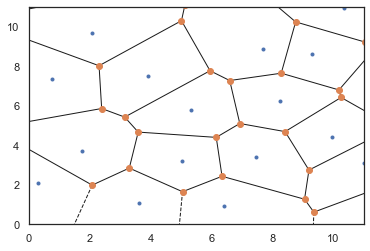

In [130]:
vor = Voronoi(grain_centers(raw_data))
fig = voronoi_plot_2d(vor)
plt.xlim(0,11)
plt.ylim(0,11)
plt.show()

In [419]:
def mod_adj_dict(data):
    coords=data[:,[3,4]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            #remove to prevent duplicates
#             neigh[j].add(i)
    return neigh

In [420]:
#goes point by point to find any misorientation > 15 degrees. How to determine SVM boundary 

In [421]:
#plot js divergence of boundary dist
def boundary_hist(array,boundary_plot=False,hist=False):    
    boundaries=np.zeros((len(array),1))
    raw_data_and_boundaries=np.concatenate((array,boundaries.reshape(-1,1)),axis=1)
    
    #create ajd dict
    modified_vor_adj=mod_adj_dict(array)
    
    #create list of boundary disorientations
    boundaries=[]
    for key in modified_vor_adj:
        euler_one=[array[key][0],array[key][1],array[key][2]]
        for value in modified_vor_adj[key]:
            euler_two=[array[value][0],array[value][1],array[value][2]]
            vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
            if vor_disorient > 15:
                boundaries.append(vor_disorient)
                raw_data_and_boundaries[key,6]=1
                raw_data_and_boundaries[value,6]=1
    
    if boundary_plot==True:
        raw_data_and_boundaries_slice=raw_data_and_boundaries[np.where(raw_data_and_boundaries[:,6]==1)]
        plt.xlim(0,11)
        plt.ylim(0,11)
        sns.scatterplot(x=raw_data_and_boundaries_slice[:,3],y=raw_data_and_boundaries_slice[:,4],marker='+')
    
    if hist==True:
        plt.hist(boundaries, bins=np.arange(15,100,5), range=(15,100), density=True) 
        
    return boundaries
        
#     q_hist, q_bin_edges = np.histogram(boundaries, bins=np.arange(15,100), range=(15,100), density=True)
#     q_hist = np.append(q_hist, 0)
#     q=q_hist
#     q[q==0]=[0.0000000000001]
#     return q

# #     #if none, return zeros?

In [422]:
boundaries=boundary_hist(raw_data)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


(array([0.01175337, 0.01490762, 0.01814341, 0.01855483, 0.01368817,
        0.01098983, 0.00942568, 0.00883263, 0.01096388, 0.01138642,
        0.01020034, 0.01272077, 0.01162735, 0.01452214, 0.01892919,
        0.0033544 ]),
 array([15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]),
 <a list of 16 Patch objects>)

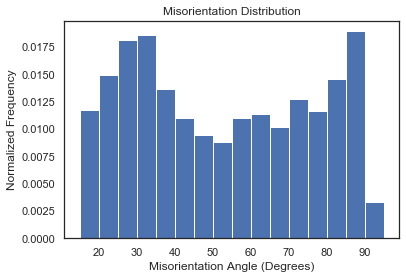

In [423]:
plt.title("Misorientation Distribution")
plt.xlabel('Misorientation Angle (Degrees)')
plt.ylabel('Normalized Frequency')
plt.hist(boundaries, bins=np.arange(15,100,5), range=(15,100), density=True) 

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


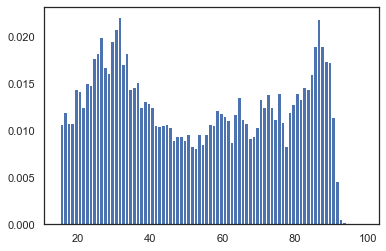

In [309]:
boundary_p=boundary_hist(raw_data,hist=True)

In [51]:
def random_boundary(sample):
    random_raw_data=raw_data[np.random.choice(raw_data.shape[0], sample, replace=False), :]
    return boundary_hist(random_raw_data,hist=True)

In [316]:
print(500/87017*100)

0.5746003654458324


0.014045707172560748


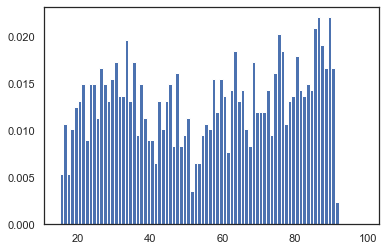

In [313]:
print(js_divergence_scipy(boundary_p,random_boundary(500)))

In [117]:
print(50/87017*100)
print(js_divergence_scipy(boundary_p,random_boundary(50)))

0.057460036544583246


NameError: name 'boundary_p' is not defined

In [43]:
def grid_boundary(res,start=0):
    grid_raw_data=raw_data[start::res]
    return boundary_hist(grid_raw_data)

In [44]:
def fine_grid_boundary(res):
    arr = np.arange(0,len(raw_data),res)
    mask = np.ones(len(raw_data), dtype=bool)
    mask[arr] = False
    fine_grid_raw_data = raw_data[mask]
    return boundary_hist(fine_grid_raw_data)

In [45]:
def window_boundary(percent):
    percent=percent/100
    row_list=[]
    for index in range(0,len(raw_data)):
        if (raw_data[index,0]<int((110*percent))) and (raw_data[index,1]<int((110*percent))):
            row_list.append(raw_data[index])
        else:
            continue

    row_tuple=tuple(row_list)
    raw_data_slice=np.vstack(row_tuple)
    
    return boundary_hist(raw_data_slice, hist=True)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


array([2.12431157e-02, 5.50747443e-03, 3.61919748e-02, 2.59638080e-02,
       3.14712825e-02, 1.80959874e-02, 2.75373721e-02, 4.09126672e-02,
       3.54051928e-02, 6.92368214e-02, 6.29425649e-02, 7.00236035e-02,
       7.47442958e-02, 5.19276161e-02, 6.76632573e-02, 5.19276161e-02,
       2.83241542e-02, 3.30448466e-02, 5.11408340e-02, 1.80959874e-02,
       3.38316286e-02, 1.80959874e-02, 1.65224233e-02, 2.75373721e-02,
       2.28166798e-02, 2.67505901e-02, 1.10149489e-02, 4.72069237e-03,
       2.36034618e-03, 7.86782061e-03, 3.14712825e-03, 7.86782061e-04,
       1.00000000e-13, 1.00000000e-13, 7.86782061e-04, 1.00000000e-13,
       1.00000000e-13, 7.86782061e-04, 1.57356412e-03, 1.00000000e-13,
       1.00000000e-13, 1.00000000e-13, 1.00000000e-13, 1.00000000e-13,
       1.00000000e-13, 1.00000000e-13, 1.00000000e-13, 1.00000000e-13,
       1.00000000e-13, 1.00000000e-13, 1.00000000e-13, 1.00000000e-13,
       1.00000000e-13, 1.00000000e-13, 1.00000000e-13, 1.00000000e-13,
      

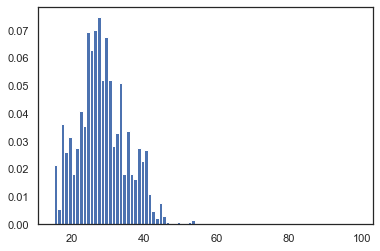

In [459]:
window_boundary(1)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


0.37815003480781756


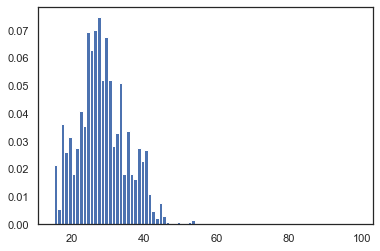

In [460]:
print(js_divergence_scipy(boundary_p,window_boundary()))

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


3.994892230826465e-05


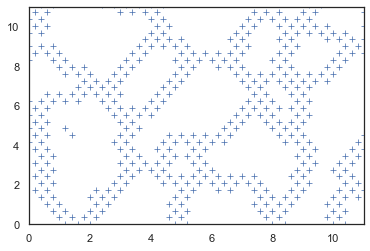

In [189]:
print(js_divergence_scipy(boundary_p,random_boundary(87017)))

In [191]:
random_boundary_percent=[]
for x in range (100,87000,1000):
    random_boundary_percent.append((x/87000)*100)
    
grid_boundary_percent=[]
for x in range(1,25,1):
    grid_boundary_percent.append(((87017/x)/87017)*100)
    
fine_grid_boundary_percent=[]
for x in range(2,25,1):
    fine_grid_boundary_percent.append(((87017-(87017/x))/87017)*100)
    
window_boundary_percent=[]
for x in range(1,100,1):
    window_boundary_percent.append(x)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


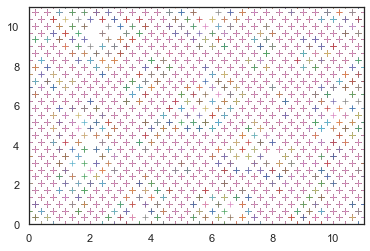

In [192]:
random_boundaries=[]
for x in range (100,87000,1000):
    random_boundaries.append(js_divergence_scipy(boundary_p, random_boundary(x)))

In [193]:
grid_boundaries=[]
for x in range(1,25,1):
    grid_boundaries.append(js_divergence_scipy(boundary_p, grid_boundary(x)))

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


In [194]:
fine_grid_boundaries=[]
for x in range(2,25,1):
    fine_grid_boundaries.append(js_divergence_scipy(boundary_p, fine_grid_boundary(x)))

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


In [195]:
window_boundaries=[]
for x in range(1,100,1):
    window_boundaries.append(js_divergence_scipy(boundary_p, window_boundary(sqrt(x*100))))

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


In [455]:
window_boundaries[0]

0.0

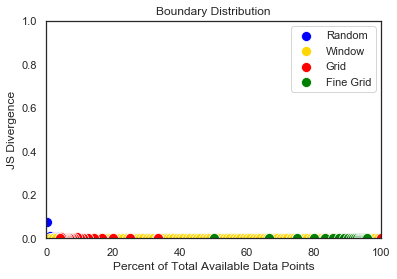

In [199]:
plt.xlim(0, 100)
plt.ylim(0, 1)
#plt.title('JS Divergence of Dataset and Grid Sampled Subset')
plt.title('Boundary Distribution')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')
#Random
sns.scatterplot(random_boundary_percent, random_boundaries, s=100, color="blue", marker="o", label='Random')
#Window
sns.scatterplot(window_boundary_percent, window_boundaries, s=100, color="gold", marker="o", label='Window')
#Grid
sns.scatterplot(grid_boundary_percent, grid_boundaries, s=100, color="red", marker="o", label='Grid')
#Fine Grid
sns.scatterplot(fine_grid_boundary_percent, fine_grid_boundaries, s=100, color="green", marker="o", label='Fine Grid')

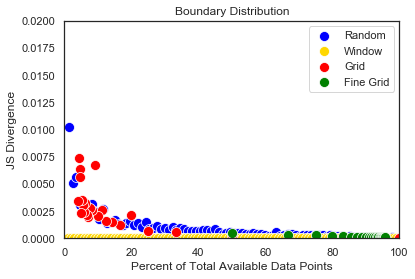

In [315]:
plt.xlim(0, 100)
plt.ylim(0, 0.02)
#plt.title('JS Divergence of Dataset and Grid Sampled Subset')
plt.title('Boundary Distribution')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')
#Random
sns.scatterplot(random_boundary_percent, random_boundaries, s=100, color="blue", marker="o", label='Random')
#Window
sns.scatterplot(window_boundary_percent, window_boundaries, s=100, color="gold", marker="o", label='Window')
#Grid
sns.scatterplot(grid_boundary_percent, grid_boundaries, s=100, color="red", marker="o", label='Grid')
#Fine Grid
sns.scatterplot(fine_grid_boundary_percent, fine_grid_boundaries, s=100, color="green", marker="o", label='Fine Grid')

In [76]:
# def avg_intergrain_disorient(grain_slice_one,grain_slice_two,plot=False):
#     inter=[]

#     #create indices for arrays
#     iter_one=range(0,len(grain_slice_one))
#     iter_two=range(0,len(grain_slice_two))
#     #cartesian product
#     product=itertools.product(iter_one, iter_two)
    
# #     print(grain_slice_one)
# #     print(grain_slice_two)
    
#     for x in product:
#         euler_one=[grain_slice_one[x[0]][0],grain_slice_one[x[0]][1],grain_slice_one[x[0]][2]]
#         euler_two=[grain_slice_two[x[1]][0],grain_slice_two[x[1]][1],grain_slice_two[x[1]][2]]
#         inter.append(disorientation(euler_one,euler_two,hex_sym_ops))
    
#     if plot==True:
#         #plot
#         plt.hist(inter, bins='auto')   
    
#     #return mean disorientation
#     return np.mean(inter)

In [77]:
# #plot js divergence of boundary dist
# def new_boundary_hist(array,binsize=249,hist=False):
#     #create ajd dict
#     modified_vor_adj=mod_adj_dict(array)
    
#     #create list of boundary disorientations
#     boundaries=[]
#     for key in modified_vor_adj:
#         grain_ID_one=array[key][5]
#         grain_slice_one=array[np.where(array[:,5]==grain_ID_one)]
#         for value in modified_vor_adj[key]:
#             grain_ID_two=array[value][5]
#             grain_slice_two=array[np.where(array[:,5]==grain_ID_two)]
#             #add average disorientation between the two grains
#             boundaries.append(avg_intergrain_disorient(grain_slice_one,grain_slice_two))
    
#     if hist==True:
#         plt.hist(boundaries, bins='auto') 
        
#     q_hist, q_bin_edges = np.histogram(boundaries, bins=np.arange(binsize), range=(0,250), density=True)
#     q_hist = np.append(q_hist, 0)
#     q=q_hist
#     q[q==0]=[0.0000000000001]
#     return q

#     #if none, return zeros?

In [78]:
# start = time.time()
# new_boundary_hist(raw_data,hist=True)
# end = time.time()
# print(end - start)

In [289]:
# # create grain adj dict
# grain_neigh=defaultdict(set)

# # get unique edge grain IDs to iterate over
# unique_edge_grain_IDs=np.unique(rdb[:,5])
# unique_edge_grain_IDs=unique_edge_grain_IDs[1:]

# #go through each grain ID
# for grain_ID in unique_edge_grain_IDs:
#     # get the row IDs of the edge points
#     row_IDs=rdb[np.where(rdb[:,5]==grain_ID),7]
#     rows_IDs=list(rows_IDs[0])
    
#     neighbor_row_IDs=[]
#     #get the row IDs of the edge neighbors
#     for row_ID in row_IDs:
        
#         for 
    
    
    
# #     neighbor_row_IDs=new
    
# #     #store their edge grains
# #     lrdb_grain_neighbor_slice=lrdb_slice[np.where((lrdb_slice[:,6]==grain_ID),5)]
    
# #     # get neighboring grain_IDs
    
    
    
    
# #     neigh[grain_ID].add(neighbor_grain_ID)
    
    
    
    
# # print(grain_neigh)

In [200]:
# #plot js divergence of boundary dist
# def boundaries(array,binsize=249,boundary_plot=False,hist=False):    
#     boundaries=np.zeros((len(array),1))
#     raw_data_and_boundaries=np.concatenate((array,boundaries.reshape(-1,1)),axis=1)
    
#     #create ajd dict
#     modified_vor_adj=mod_adj_dict(array)
    
# #     #create list of boundary disorientations
# #     boundaries=[]
# #     for key in modified_vor_adj:
# #         euler_one=[array[key][0],array[key][1],array[key][2]]
# #         for value in modified_vor_adj[key]:
# #             euler_two=[array[value][0],array[value][1],array[value][2]]
# #             vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
# #             if vor_disorient > 15:
# #                 boundaries.append(vor_disorient)
# #                 raw_data_and_boundaries[key,6]=1
# #                 raw_data_and_boundaries[value,6]=1
                
#     #recursive boundary tracer
#     #find the first boundary
    
    
#     if boundary_plot==True:
#         raw_data_and_boundaries_slice=raw_data_and_boundaries[np.where(raw_data_and_boundaries[:,6]==1)]
#         plt.xlim(0,11)
#         plt.ylim(0,11)
#         sns.scatterplot(x=raw_data_and_boundaries_slice[:,3],y=raw_data_and_boundaries_slice[:,4],marker='+')

In [201]:
# def grain_boundary_areas(grain_ID):
#     grain_boundaries=raw_data_and_boundaries_slice[np.where(raw_data_and_boundaries_slice[:,6]==1)]
# #     for grain_ID in raw_data_and_boundaries_slice[:,6]:
#     grain_ID=1
#     grain_boundary=raw_data_and_boundaries_slice[np.where(raw_data_and_boundaries_slice[:,5]==grain_ID)]
        


#     plt.xlim(0,11)
#     plt.ylim(0,11)
#     sns.scatterplot(x=grain_boundary[:,3],y=grain_boundary[:,4],marker='+')

In [34]:
#creates dictionary of indices and neighboring indices
def adj_dict(data):
    coords=data[:,[3,4]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            neigh[j].add(i)
    return neigh

In [35]:
#start with nucleus
def rec_vor(row_ID,grain_ID,data_sample,angle):
    #assign angle
    euler_one=[data_sample[row_ID,0],data_sample[row_ID,1],data_sample[row_ID,2]]
    #sample each surrounding point
    for row_ID_2 in new_vor_adj[row_ID]:
        #make sure grain grows outwards, 'memoization'
        if data_sample[row_ID_2,5]==0:
            #assign second angle
            euler_two=[data_sample[row_ID_2,0],data_sample[row_ID_2,1],data_sample[row_ID_2,2]]
            #if they have a similar orientation, add to the grain, recursivly search
#             if (misorientation(euler_one,euler_two) <= angle):
            if (disorientation(euler_one, euler_two,hex_sym_ops) <= angle):
                # prevent infinite flip-flop recursion
                if data_sample[row_ID_2,5] != grain_ID:
                    data_sample[row_ID_2,5]=grain_ID
                    rec_vor(row_ID_2,grain_ID,data_sample,angle)
            #label edges
            else:
                data_sample[row_ID,6]=1
                data_sample[row_ID_2,6]=1

In [36]:
#label the grains in an array
def rec_grains(data_sample,angle=15):
    #assign first grain ID
    grain_ID=1
    #set all grains to 0
    data_sample[:,5]=0
    #loop until 
    while True:
        #ID is 0 if unassigned
        unassigned=np.where(data_sample[:,5]==0) 
        #if all grains are assigned
        if len(unassigned[0])==0:
            #returned the labeled array and plot a graph
#             sns.scatterplot(x=data_sample[:,3],y=data_sample[:,4],marker='o',hue=data_sample[:,5],palette=new_cmap)
            return data_sample
        #find first
        row_ID=unassigned[0][0]
        data_sample[row_ID,5]=1
        rec_vor(row_ID,grain_ID,data_sample,angle)
        grain_ID+=1                    

In [37]:
#start with nucleus
def rec_neigh_vor(row_ID,grain_ID,data_sample,angle):
    #assign angle
    euler_one=[data_sample[row_ID,0],data_sample[row_ID,1],data_sample[row_ID,2]]
    #sample each surrounding point
    for row_ID_2 in new_vor_adj[row_ID]:
        #make sure grain grows outwards, 'memoization'
        if data_sample[row_ID_2,7]==0:
            #assign second angle
            euler_two=[data_sample[row_ID_2,0],data_sample[row_ID_2,1],data_sample[row_ID_2,2]]
            #if they have a similar orientation, add to the grain, recursivly search
            if (disorientation(euler_one, euler_two,hex_sym_ops) <= angle):
                # prevent infinite flip-flop recursion
                if data_sample[row_ID_2,7] != grain_ID:
                    data_sample[row_ID_2,7]=grain_ID
                    rec_vor(row_ID_2,grain_ID,data_sample,angle)

            else:
                #label edges
                data_sample[row_ID,6]=1
                data_sample[row_ID_2,6]=1
                
                #create adj grain dict
                grain_ID_one=data_sample[row_ID,5]
                grain_ID_two=data_sample[row_ID_2,5]
                grain_neigh[int(grain_ID_one)].add(int(grain_ID_two))
                
                #add adj grains to a point
                data_sample[row_ID,8]=data_sample[row_ID_2,5]
                data_sample[row_ID_2,8]=data_sample[row_ID,5]

In [38]:
#label the grains in an array
def rec_neighbors(data_sample,angle=15):
    #assign first grain ID
    grain_ID=1
    #set all grains to 0
    data_sample[:,7]=0
    #loop until 
    while True:
        #ID is 0 if unassigned
        unassigned=np.where(data_sample[:,7]==0) 
        #if all grains are assigned
        if len(unassigned[0])==0:
            #returned the labeled array and plot a graph
#             sns.scatterplot(x=data_sample[:,3],y=data_sample[:,4],marker='o',hue=data_sample[:,5],palette=new_cmap)
            return data_sample
        #find first
        row_ID=unassigned[0][0]
        data_sample[row_ID,7]=1
        rec_neigh_vor(row_ID,grain_ID,data_sample,angle)
        grain_ID+=1                    

In [ ]:
#assume each grain has 10 neighbors, therefore 100,000 * 10 to store = 1,000,000 np array len

In [52]:
#load and configure data
raw_data = np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8))

#add boundaries - 6
boundaries=np.zeros((len(raw_data),1))
raw_data_and_boundaries=np.concatenate((raw_data,boundaries.reshape(-1,1)),axis=1)

#add neighbors for rec_neighbors - 7
neighbors=np.zeros((len(raw_data),1))
raw_data_and_boundaries=np.concatenate((raw_data_and_boundaries,neighbors.reshape(-1,1)),axis=1)

#add neighbors for points/grains - 8
raw_data_and_boundaries=np.concatenate((raw_data_and_boundaries,neighbors.reshape(-1,1)),axis=1)

#add row_IDs for adj dict - 9
row_IDs=np.arange(1,len(raw_data)+1)
raw_data_and_boundaries=np.concatenate((raw_data_and_boundaries,row_IDs.reshape(-1,1)),axis=1)

#add column for len calculation - 10
length=np.zeros((len(raw_data),1))
raw_data_and_boundaries=np.concatenate((raw_data_and_boundaries,length.reshape(-1,1)),axis=1)

#get rid of grain ID 1, something wrong
# raw_data_and_boundaries=raw_data_and_boundaries[np.where(raw_data_and_boundaries[:,5] != 1)]

#create adj dict
new_vor_adj=adj_dict(raw_data_and_boundaries)

rdb=raw_data_and_boundaries

#label grains and edges
rdb=rec_grains(rdb)

# create grain adj dict
grain_neigh=defaultdict(set)

rdb=rec_neighbors(rdb)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


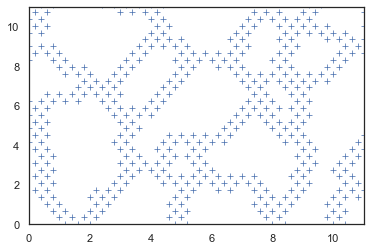

In [52]:
#plot labeled edges
rdb_slice=rdb[np.where(rdb[:,6]==1)]
plt.xlim(0,11)
plt.ylim(0,11)
sns.scatterplot(x=rdb_slice[:,3],y=rdb_slice[:,4],marker='+')

In [79]:
def svc_decision_boundary(model,x_lim=(0,10),y_lim=(0,10),numb=30):
    """Return the decision boundary coordinates for a 2D SVC"""

#     x_lim=(2,8)
#     y_lim=(0,4)
    
    # create grid to evaluate model
    x = np.linspace(x_lim[0], x_lim[1], numb)
    y = np.linspace(y_lim[0], y_lim[1], numb)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    boundary=plt.contour(X, Y, P, colors='k',
               levels=[0], alpha=0.5,
               linestyles=['-'])
    plt.close()
    
    p = boundary.collections[0].get_paths()[0]
    v = p.vertices
    boundary_coords = v[:,[0,1]]
    
    return boundary_coords

In [80]:
def svc_decision_boundary_length(model,x_lim=(0,10),y_lim=(0,10),numb=300):
    """Return the decision boundary coordinates for a 2D SVC"""

#     x_lim=(2,8)
#     y_lim=(0,4)
    
    # create grid to evaluate model
    x = np.linspace(x_lim[0], x_lim[1], numb)
    y = np.linspace(y_lim[0], y_lim[1], numb)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    
    boundary=plt.contour(X, Y, P, colors='k',
               levels=[0], alpha=0.5,
               linestyles=['-'])
    plt.close()
    
    p = boundary.collections[0].get_paths()[0]
    v = p.vertices
    boundary_coords = v[:,[0,1]]
    
    x = np.ravel(boundary_coords[:,0])
    y = np.ravel(boundary_coords[:,1])

    dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2

    return np.sum(np.sqrt(dist_array))

In [77]:
#create array to minimize data requirement
x=0
for grain_ID_1_ in np.unique(rdb[:,5]):
    for grain_ID_2_ in grain_neigh[grain_ID_1_]:
        x+=1
print(x)

4823


In [424]:
#initialize misorientations and lengths/weights for histogram
avg_boundary_disorients = np.zeros((5000,1))
boundary_lens = np.zeros((5000,1))

#create point adj dict
point_adj=adj_dict(rdb)

index=0
# for each grain
for grain_ID_1_ in np.unique(rdb[:,5]):
    #get the points and edges of the grain
    rdb_slice_1_=rdb[np.where(rdb[:,5]==grain_ID_1_)]
    rdb_edge_1_=rdb_slice_1_[np.where(rdb_slice_1_[:,6]==1)]
    
    #for each neighboring grain
    for grain_ID_2_ in grain_neigh[grain_ID_1_]:
        #don't comapre the same grain
        if int(grain_ID_1_) != int(grain_ID_2_):
            #get the boundary points of grain 1 with grain 2
            rdb_boundary_1_=rdb_edge_1_[np.where(rdb_edge_1_[:,8]==grain_ID_2_)]

            #slice grain 2
            rdb_slice_2_=rdb[np.where(rdb[:,5]==grain_ID_2_)]
            rdb_edge_2_=rdb_slice_2_[np.where(rdb_slice_2_[:,6]==1)]
            rdb_boundary_2_=rdb_edge_2_[np.where(rdb_edge_2_[:,8]==grain_ID_1_)]

            #create list of boundary disorientations
            boundaries_=[]

            #find each misorientation
            for key in rdb_boundary_1_[:,9]:
                key=int(key)
                euler_one_=[rdb[key][0],rdb[key][1],rdb[key][2]]
                for value in point_adj[key]:
                    euler_two_=[rdb[value][0],rdb[value][1],rdb[value][2]]
                    vor_disorient_=disorientation(euler_one_,euler_two_,hex_sym_ops)
                    if vor_disorient_ > 15:
                        boundaries_.append(vor_disorient_)

            #get avg and append to array
            if len(boundaries_)>0:
                avg_boundary_disorient=sum(boundaries_)/len(boundaries_)
                avg_boundary_disorients[index]=avg_boundary_disorient
            else:
                avg_boundary_disorients[index]=0

            #append boundaries together
            rdb_boundary_=np.append(rdb_boundary_1_, rdb_boundary_2_, axis=0)
            
            #slice boundary
            X=rdb_boundary_[:,3:5]
            y=rdb_boundary_[:,5]
            
            #if no points, bad
            if len(X) < 2:
                break
            
            #don't sample the same grain
            if len(np.unique(y)) < 2:
                break

            #create model
            model = SVC(kernel='rbf', C=1e10, gamma=1)
            model.fit(X, y)
            #return length
            boundary_len_=svc_decision_boundary_length(model,x_lim=(min(X[:,0]),max(X[:,0])),y_lim=(min(X[:,1]),max(X[:,1])),numb=30)

            # append boundary length
            boundary_lens[index]=boundary_len_
           
            index+=1

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encount

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


In [441]:
keep=np.where(avg_boundary_disorients>15)
avg_boundary_disorients_over15 = avg_boundary_disorients[keep]
boundary_lens_over15 = boundary_lens[keep]

(array([2.434e-01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 7.000e-04, 3.200e-03, 4.900e-03, 5.900e-03, 5.700e-03,
        7.900e-03, 8.800e-03, 8.300e-03, 9.700e-03, 7.900e-03, 6.900e-03,
        7.900e-03, 8.800e-03, 6.600e-03, 6.800e-03, 6.700e-03, 6.400e-03,
        6.800e-03, 5.700e-03, 7.500e-03, 7.400e-03, 7.200e-03, 8.100e-03,
        7.900e-03, 6.400e-03, 7.000e-03, 6.100e-03, 6.300e-03, 7.300e-03,
        7.600e-03, 6.100e-03, 6.600e-03, 6.900e-03, 7.000e-03, 5.400e-03,
        6.700e-03, 6.000e-03, 5.700e-03, 1.700e-03, 1.000e-04, 0.000e+00,
        0.000e+00]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]),
 <a list of 49 Patch objects>)

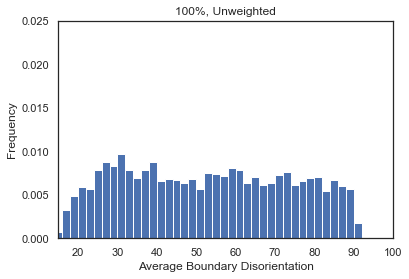

In [431]:
#unweighted
plt.xlim(15,100)
plt.ylim(0,0.025)
plt.title("100%, Unweighted")
plt.xlabel('Average Boundary Disorientation')
plt.ylabel('Frequency')
plt.hist(avg_boundary_disorients, bins=np.arange(0,100,2), range=(0,100), density=True)

(array([6.70754400e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.34251509e-04,
        4.45771695e-03, 7.64789574e-03, 9.36021801e-03, 1.06289525e-02,
        1.53481448e-02, 1.53968071e-02, 1.30808828e-02, 1.87577041e-02,
        1.76753057e-02, 1.26413938e-02, 1.40324186e-02, 1.49402683e-02,
        1.11401919e-02, 1.04469348e-02, 1.19458703e-02, 9.72953362e-03,
        1.08109004e-02, 8.46533321e-03, 1.08022063e-02, 8.89577968e-03,
        1.20388472e-02, 1.40757848e-02, 1.35754152e-02, 7.97817978e-03,
        1.06919109e-02, 8.12132925e-03, 8.50604541e-03, 1.14309597e-02,
        1.35038116e-02, 1.02026925e-02, 1.25708250e-02, 1.04255616e-02,
        1.53018793e-02, 1.18871506e-02, 1.15270260e-02, 1.02788984e-02,
        1.17415999e-02, 2.28798950e-03, 3.99432976e-05, 0.00000000e+00,
        0.00000000e+00]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46

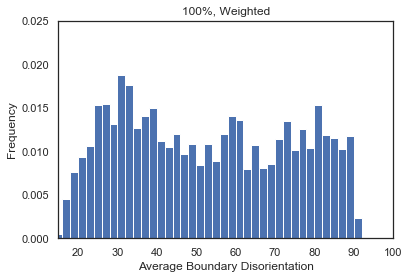

In [433]:
#weighted
plt.xlim(15,100)
plt.ylim(0,0.025)
plt.title("100%, Weighted")
plt.xlabel('Average Boundary Disorientation')
plt.ylabel('Frequency')
plt.hist(avg_boundary_disorients, bins=np.arange(0,100,2), range=(0,100), density=True, weights=np.asarray(boundary_lens))

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00136399, 0.00623539, 0.00954793,
        0.01149649, 0.01110678, 0.01539361, 0.01714731, 0.01617303,
        0.01890101, 0.01539361, 0.01344505, 0.01539361, 0.01714731,
        0.01286048, 0.01325019, 0.01305534, 0.01247077, 0.01325019,
        0.01110678, 0.01461419, 0.01441933, 0.01402962, 0.01578332,
        0.01539361, 0.01247077, 0.01363991, 0.0118862 , 0.01227592,
        0.01422447, 0.01480904, 0.0118862 , 0.01286048, 0.01344505,
        0.01363991, 0.01052221, 0.01305534, 0.01169135, 0.01110678,
        0.00331255, 0.00019486, 0.        , 0.        ]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]),
 <a list of 49 Patch objects>)

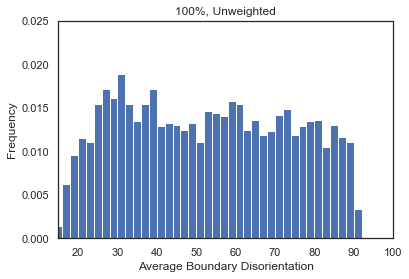

In [444]:
#unweighted
plt.xlim(15,100)
plt.ylim(0,0.025)
plt.title("100%, Unweighted")
plt.xlabel('Average Boundary Disorientation')
plt.ylabel('Frequency')
plt.hist(avg_boundary_disorients_over15, bins=np.arange(0,100,2), range=(0,100), density=True)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.17026104e-04,
        5.14837614e-03, 8.83282729e-03, 1.08104493e-02, 1.22757560e-02,
        1.77261193e-02, 1.77823212e-02, 1.51075777e-02, 2.16639408e-02,
        2.04138403e-02, 1.45999961e-02, 1.62065402e-02, 1.72550481e-02,
        1.28662046e-02, 1.20655372e-02, 1.37967113e-02, 1.12369851e-02,
        1.24858941e-02, 9.77691495e-03, 1.24758529e-02, 1.02740529e-02,
        1.39040936e-02, 1.62566254e-02, 1.56787307e-02, 9.21428410e-03,
        1.23484688e-02, 9.37961252e-03, 9.82393492e-03, 1.32020227e-02,
        1.55960332e-02, 1.17834531e-02, 1.45184937e-02, 1.20408526e-02,
        1.76726856e-02, 1.37288938e-02, 1.33129730e-02, 1.18714660e-02,
        1.35607921e-02, 2.64248059e-03, 4.61319376e-05, 0.00000000e+00,
        0.00000000e+00]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46

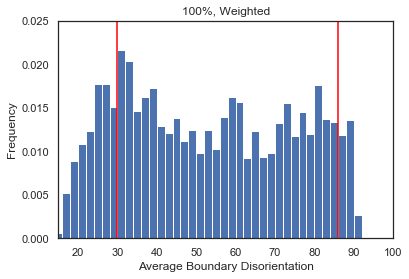

In [448]:
#weighted
plt.xlim(15,100)
plt.ylim(0,0.025)
plt.title("100%, Weighted")
plt.xlabel('Average Boundary Disorientation')
plt.ylabel('Frequency')
plt.axvline(x=30, color='red')
plt.axvline(86, color='red')
plt.hist(avg_boundary_disorients_over15, bins=np.arange(0,100,2), range=(0,100), density=True, weights=np.asarray(boundary_lens_over15))

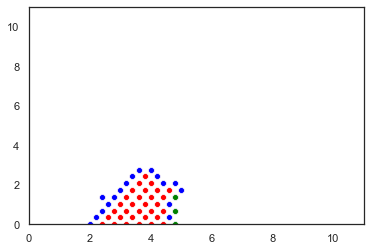

In [241]:
rdb_slice_1=rdb[np.where(rdb[:,5]==2)]
rdb_edge_1=rdb_slice_1[np.where(rdb_slice_1[:,6]==1)]
rdb_boundary_1=rdb_edge_1[np.where(rdb_edge_1[:,8]==3)]

#plot labeled grains
plt.xlim(0,11)
plt.ylim(0,11)
sns.scatterplot(x=rdb_slice_1[:,3],y=rdb_slice_1[:,4],marker='o',color='red')
sns.scatterplot(x=rdb_edge_1[:,3],y=rdb_edge_1[:,4],marker='o',color='blue')
sns.scatterplot(x=rdb_boundary_1[:,3],y=rdb_boundary_1[:,4],marker='o',color='green')

In [248]:
# rdb_test_slice=rdb[[42548,42273, 42274, 42549, 42822, 42823],3:5]
# plt.scatter(rdb_test_slice[:,0],rdb_test_slice[:,1])

In [249]:
#create list of boundary disorientations
boundaries=[]

#find each misorientation
for key in rdb_boundary_1[:,9]:
    key=int(key)
    euler_one=[rdb[key][0],rdb[key][1],rdb[key][2]]
    for value in point_adj[key]:
        euler_two=[rdb[value][0],rdb[value][1],rdb[value][2]]
        vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
        if vor_disorient > 15:
            boundaries.append(vor_disorient)
            
#get avg and append to array
print(boundaries)
avg=sum(boundaries)/len(boundaries)
print(avg)

[43.99800845583731, 44.131184832739386, 43.91944582109358, 44.169516516251996]
44.054538906480566


C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos


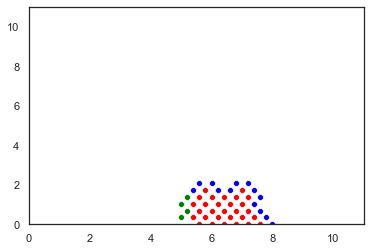

In [37]:
rdb_slice_2=rdb[np.where(rdb[:,5]==3)]
rdb_edge_2=rdb_slice_2[np.where(rdb_slice_2[:,6]==1)]
rdb_boundary_2=rdb_edge_2[np.where(rdb_edge_2[:,8]==2)]

#plot labeled grains
plt.xlim(0,11)
plt.ylim(0,11)
sns.scatterplot(x=rdb_slice_2[:,3],y=rdb_slice_2[:,4],marker='o',color='red')
sns.scatterplot(x=rdb_edge_2[:,3],y=rdb_edge_2[:,4],marker='o',color='blue')
sns.scatterplot(x=rdb_boundary_2[:,3],y=rdb_boundary_2[:,4],marker='o',color='green')

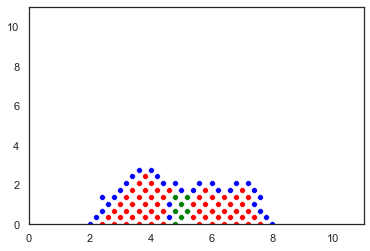

In [38]:
plt.xlim(0,11)
plt.ylim(0,11)
sns.scatterplot(x=rdb_slice_1[:,3],y=rdb_slice_1[:,4],marker='o',color='red')
sns.scatterplot(x=rdb_edge_1[:,3],y=rdb_edge_1[:,4],marker='o',color='blue')
sns.scatterplot(x=rdb_boundary_1[:,3],y=rdb_boundary_1[:,4],marker='o',color='green')
sns.scatterplot(x=rdb_slice_2[:,3],y=rdb_slice_2[:,4],marker='o',color='red')
sns.scatterplot(x=rdb_edge_2[:,3],y=rdb_edge_2[:,4],marker='o',color='blue')
sns.scatterplot(x=rdb_boundary_2[:,3],y=rdb_boundary_2[:,4],marker='o',color='green')

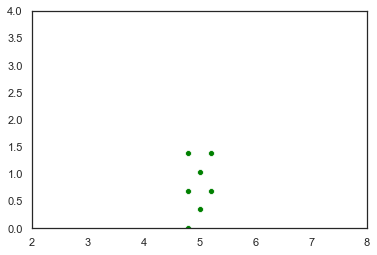

In [39]:
plt.xlim(2,8)
plt.ylim(0,4)
rdb_boundary=np.append(rdb_boundary_1, rdb_boundary_2, axis=0)
sns.scatterplot(x=rdb_boundary[:,3],y=rdb_boundary[:,4],marker='o',color='green')

In [235]:
#slice boundary
X=rdb_boundary[:,3:5]
y=rdb_boundary[:,5]

#create model
model = SVC(kernel='rbf', C=1e10, gamma=1)
model.fit(X, y)

# #plot model
# plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
# plot_svc_decision_function(model);

# #plot boundary
# coords=svc_decision_boundary(model,x_lim=(min(X[:,0]),max(X[:,0])),y_lim=(min(X[:,1]),max(X[:,1])),numb=30);
# plt.scatter(coords[:,0],coords[:,1])

#return length
length=svc_decision_boundary_length(model,x_lim=(min(X[:,0]),max(X[:,0])),y_lim=(min(X[:,1]),max(X[:,1])),numb=30)
print(length)

1.389615845855121


In [138]:
# def plot_svc_decision_function(model, ax=None, plot_support=True):
#     """Plot the decision function for a 2D SVC"""
#     if ax is None:
#         ax = plt.gca()
#     xlim = ax.get_xlim()
#     ylim = ax.get_ylim()
    
#     # create grid to evaluate model
#     x = np.linspace(xlim[0], xlim[1], 30)
#     y = np.linspace(ylim[0], ylim[1], 30)
#     Y, X = np.meshgrid(y, x)
#     xy = np.vstack([X.ravel(), Y.ravel()]).T
#     P = model.decision_function(xy).reshape(X.shape)
    
#     # plot decision boundary and margins
#     ax.contour(X, Y, P, colors='k',
#                levels=[-1, 0, 1], alpha=0.5,
#                linestyles=['--', '-', '--'])
    
#     # plot support vectors
#     if plot_support:
#         ax.scatter(model.support_vectors_[:, 0],
#                    model.support_vectors_[:, 1],
#                    s=300, linewidth=1, facecolors='none');
#     ax.set_xlim(xlim)
#     ax.set_ylim(ylim)

# logic=(rdb_boundary[:,5]==2) | (rdb_boundary[:,5]==3)
# coords=rdb_boundary[np.where(logic)]
# # coords=rdb_boundary[:,[3,4]]
# X=coords[:,[3,4]]
# IDs=rdb_boundary[np.where(logic),5]
# # IDs=rdb_boundary[:,5]
# y=IDs[0]

# #create model
# #use a high value of C to heavily penalize misclassified data (keep grains seperate)
# #use a high value of gamma to allow curve to fit to individuals points - 'waviness' 
# model = SVC(kernel='rbf', C=1e10, gamma=10)
# model.fit(X, y)

# #plot model
# plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
# plot_svc_decision_function(model);

# #return support vector
# # model.support_vectors_

# #function to call recursive edge function
# def edge_len(array): 
#     #create array
# #     boundaries=np.zeros((len(array),1))
# #     raw_data_and_boundaries=np.concatenate((array,boundaries.reshape(-1,1)),axis=1)

#     #create point adjacency dictionary
#     modified_vor_adj=mod_adj_dict(array)
    
#     # store the sampling path length, assuming constant speed, is proportional to scan time
#     path_len = 0
    
#     #if the starting point is found
#     found=False
    
#     #find the starting point using a raster scan
#     for key in modified_vor_adj:
#         if found==False:
#             euler_one=[array[key][0],array[key][1],array[key][2]]
#             for value in modified_vor_adj[key]:
#                 euler_two=[array[value][0],array[value][1],array[value][2]]
#                 vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
#                 if vor_disorient > 15:
#                     start=array[key,9]
#                     array[key,6]=1
#                     array[value,6]=1
#                     found=True
#                     break             
#         else: 
#             break
#     #function to label all edge grains recursively
#     edge_vor(start,array)

# #recursive edge function
# def edge_len_vor(row_ID,data_sample,angle=15):
#     row_ID=int(row_ID)
#     #assign angle
#     euler_one=[data_sample[row_ID,0],data_sample[row_ID,1],data_sample[row_ID,2]]
#     #sample each surrounding point
#     for row_ID_2 in new_vor_adj[row_ID]:
#         #make sure grain grows outwards, 'memoization'
#         if data_sample[row_ID_2,7]==0:
#             #assign second angle
#             euler_two=[data_sample[row_ID_2,0],data_sample[row_ID_2,1],data_sample[row_ID_2,2]]
#             #if they have a similar orientation, add to the grain, recursivly search
# #             print(disorientation(euler_one, euler_two,hex_sym_ops))
#             if (disorientation(euler_one, euler_two,hex_sym_ops) > angle):
#                 # prevent infinite flip-flop recursion
# #                 if data_sample[row_ID_2,6] != 1:
#                 data_sample[row_ID_2,6]=1
#                 edge_vor(row_ID_2,data_sample)

# #             else:
#                 #label as not edge

# #create edge following algorithm that doesn't double back, insert dummy points for border, also 

# #function to call recursive edge function
# def edge_tracer(array): 
#     #create array
# #     boundaries=np.zeros((len(array),1))
# #     raw_data_and_boundaries=np.concatenate((array,boundaries.reshape(-1,1)),axis=1)

#     #create point adjacency dictionary
#     modified_vor_adj=mod_adj_dict(array)
    
#     # store the sampling path length, assuming constant speed, is proportional to scan time
#     path_len = 0
    
#     #if the starting point is found
#     found=False
    
#     #find the starting point using a raster scan
#     for key in modified_vor_adj:
#         if found==False:
#             euler_one=[array[key][0],array[key][1],array[key][2]]
#             for value in modified_vor_adj[key]:
#                 euler_two=[array[value][0],array[value][1],array[value][2]]
#                 vor_disorient=disorientation(euler_one,euler_two,hex_sym_ops)
#                 if vor_disorient > 15:
#                     start=array[key,9]
#                     array[key,6]=1
#                     array[value,6]=1
#                     found=True
#                     break             
#         else: 
#             break
#     print('yeet')
#     print(start)
#     #function to label all edge grains recursively
#     edge_vor(start,array)

# #recursive edge function
# def edge_vor(row_ID,data_sample,angle=15):
#     row_ID=int(row_ID)
#     #assign angle
#     euler_one=[data_sample[row_ID,0],data_sample[row_ID,1],data_sample[row_ID,2]]
#     #sample each surrounding point
#     for row_ID_2 in new_vor_adj[row_ID]:
#         #make sure grain grows outwards, 'memoization'
#         if data_sample[row_ID_2,7]==0:
#             #assign second angle
#             euler_two=[data_sample[row_ID_2,0],data_sample[row_ID_2,1],data_sample[row_ID_2,2]]
#             #if they have a similar orientation, add to the grain, recursivly search
# #             print(disorientation(euler_one, euler_two,hex_sym_ops))
#             if (disorientation(euler_one, euler_two,hex_sym_ops) > angle):
#                 # prevent infinite flip-flop recursion
# #                 if data_sample[row_ID_2,6] != 1:
#                 data_sample[row_ID_2,6]=1
#                 edge_vor(row_ID_2,data_sample)

# #             else:
#                 #label as not edge

# rdb2=raw_data_and_boundaries
# rdb2=edge_tracer(rdb2)

# rdb2_slice=rdb2[np.where(rdb2[:,6]==1)]
# plt.xlim(0,11)
# plt.ylim(0,11)
# sns.scatterplot(x=rdb2_slice[:,3],y=rdb2_slice[:,4],marker='+')

# def edge_len_vor(row_ID,data_sample,angle=15):
#     row_ID=int(row_ID)
#     #sample each surrounding point
#     for row_ID_2 in new_vor_adj[row_ID]:
#         rdb_boundary_1[row_ID_2,10]=1
#         edge_vor(row_ID_2,data_sample)

# boundary_adj=new_vor_adj[rdb_boundary_1[:,9]]

# boundary_lens = []

# #run until all lengths are calculated
# rdb_boundary_1[0,10]=1
# boundary_len=0

# boundary_adj=new_vor_adj[rdb_boundary_1[:,9]]

# while sum(rdb_boundary_1[:,10]) < len(rdb_boundary_1[:,10]):
#     boundary_len=0
#     edge_len_vor(rdb_boundary_1[0,9])

    
# boundary_lens.append(boundary_len)

# # #label the grains in an array
# # def rec_grains(data_sample,angle=15):
# # #     #assign first grain ID
# # #     grain_ID=1
# #     #set all grains to 0
# # #     data_sample[:,5]=0
# #     #loop until 
# #     while True:
# # #         #ID is 0 if unassigned
# # #         unassigned=np.where(data_sample[:,5]==0) 
# # #         #if all grains are assigned
# # #         if len(unassigned[0])==0:
# # #             #returned the labeled array and plot a graph
# # # #             sns.scatterplot(x=data_sample[:,3],y=data_sample[:,4],marker='o',hue=data_sample[:,5],palette=new_cmap)
# # #             return data_sample
# # #         #find first
# # #         row_ID=unassigned[0][0]
# #         data_sample[row_ID,5]=1
# #         rec_vor(row_ID,grain_ID,data_sample,angle)
# #         grain_ID+=1                    

# # #start with nucleus
# # def rec_neigh_vor(row_ID,grain_ID,data_sample,angle):
# #     #assign angle
# #     euler_one=[data_sample[row_ID,0],data_sample[row_ID,1],data_sample[row_ID,2]]
# #     #sample each surrounding point
# #     for row_ID_2 in new_vor_adj[row_ID]:
# #         #make sure grain grows outwards, 'memoization'
# #         if data_sample[row_ID_2,7]==0:
# #             #assign second angle
# #             euler_two=[data_sample[row_ID_2,0],data_sample[row_ID_2,1],data_sample[row_ID_2,2]]
# #             #if they have a similar orientation, add to the grain, recursivly search
# #             if (disorientation(euler_one, euler_two,hex_sym_ops) <= angle):
# #                 # prevent infinite flip-flop recursion
# #                 if data_sample[row_ID_2,7] != grain_ID:
# #                     data_sample[row_ID_2,7]=grain_ID
# #                     rec_vor(row_ID_2,grain_ID,data_sample,angle)

# #             else:
# #                 #label edges
# #                 data_sample[row_ID,6]=1
# #                 data_sample[row_ID_2,6]=1
                
# #                 #create adj grain dict
# #                 grain_ID_one=data_sample[row_ID,5]
# #                 grain_ID_two=data_sample[row_ID_2,5]
# #                 grain_neigh[int(grain_ID_one)].add(int(grain_ID_two))
                
# #                 #add adj grains to a point
# #                 data_sample[row_ID,8]=data_sample[row_ID_2,5]
# #                 data_sample[row_ID_2,8]=data_sample[row_ID,5]